Preparing packages and initializing detector

In [ ]:
import sys
sys.path.append('C:/Users/admin/anaconda3/TOG')
import tog
from attack_utils.patch_utils import extract_roi, evaluate_vanishing_patch, evaluate_mislabeling_patch
from dataset_utils.preprocessing import letterbox_image_padded
from models.yolov3 import YOLOv3_Darknet53
from misc_utils.visualization import visualize_detections
from keras import backend as K
from tqdm import tqdm
from PIL import Image
import numpy as np
import datetime
import face_recognition as fr
import matplotlib.pyplot as plt
from pprint import pprint
np.set_printoptions(threshold=np.inf)
import cv2
import os
K.clear_session()
weights = 'C:/Users/admin/Desktop/YOLOv3_Darknet53.h5'  # Change this path to the victim model's weights
detector = YOLOv3_Darknet53(weights=weights)

Training Parameters

In [158]:
ROOT_TRAIN = 'C:/Users/admin/Desktop/celebaTest/train/img_align_celeba'  # Path to training dataset
ROOT_TEST = 'C:/Users/admin/Desktop/celebaTest/test/img_align_celeba'   #Path to testing dataset

ROOT_OUTPUT = './outputs'
NUM_EPOCHS = 5
LR_INIT = 0.5
LR_MULTIPLIER = 0.1
BATCH_SIZE = 8
TOLERANCE_MAX = 5
TOLERANCE_DELTA = 0.01
PATCH_SIZE = (26, 26)  # set size here
MIN_ROI_SIZE = PATCH_SIZE[0] * PATCH_SIZE[1] * 3
SOURCE_CLASS = 'person'
TARGET_CLASS = 'chair'

fpaths_train = [os.path.join(ROOT_TRAIN, fname) for fname in os.listdir(ROOT_TRAIN)]
fpaths_test = [os.path.join(ROOT_TEST, fname) for fname in os.listdir(ROOT_TEST)]
output_folder = os.path.join(ROOT_OUTPUT)
#os.makedirs(output_folder)

Initializing Training

In [5]:
# Uncomment if you want to train your own patch 
# Otherwise, the pretrained one is available below

#headpatch = np.full(shape=(1, *PATCH_SIZE, 3), fill_value=0.50)
#cheekpatch = np.full(shape=(1, *PATCH_SIZE, 3), fill_value=0.50)
min_loss = np.float('inf')
tolerance = 0
lr = LR_INIT

If you dont't want to train your own patch, a pretrained one is available below under "Pretrained Patch"

In [231]:
for epoch in range(NUM_EPOCHS):
    ####################################################################################################################
    # Training
    ####################################################################################################################
    epoch_loss = []
    runs=0
    head_batch_grad, head_batch_loss = [], []
    cheek_batch_grad, cheek_batch_loss = [], []
    #np.random.shuffle(fpaths_train)
    for fpath in tqdm(fpaths_train):
        #runs+=1
        # Preprocess input images
        input_img = Image.open(fpath)
        x_nat, x_bbox = letterbox_image_padded(input_img, size=detector.model_img_size)

        # Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
        detections_nat = detector.detect(x_nat)
        landmarks = fr.face_landmarks((np.array(x_nat.squeeze(0)*255).astype(int)).astype('uint8'))
        rois = extract_roi(detections_nat, detector.classes.index(SOURCE_CLASS), x_bbox, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)
        #print('run: ',runs)
        if len(landmarks) == 0:
            continue

        # Apply adversarial patch to each of the rois
        x_adv = x_nat.copy()
        detections_target = detections_nat.copy()
        
##################################################################################################################

        #forehead
        x1,_ = landmarks[0]['right_eye'][len(landmarks[0]['right_eye'])-1]
        x2, _ = landmarks[0]['left_eye'][0]
        xmin = x1 + int((x2-x1)/2)
        _,ymin = landmarks[0]['left_eyebrow'][len(landmarks[0]['left_eyebrow'])//2 +1]
        if ymin>40:
            ymin-=40

        xmax , ymax = xmin+ PATCH_SIZE[0], ymin+PATCH_SIZE[1]
        x_adv[:, ymin:ymax, xmin:xmax, :] = headpatch

##################################################################################################################                        
                        
        # left cheek 
        xmin2,_ = landmarks[0]['left_eye'][0]
        _ , ymin2 = landmarks[0]['nose_bridge'][len(landmarks[0]['nose_bridge'])//2]

        xmax2 , ymax2 = xmin2+ PATCH_SIZE[0], ymin2+PATCH_SIZE[1]
        x_adv[:, ymin2:ymax2, xmin2:xmax2, :] = cheekpatch
        
####################################################################################################################

        # Compute gradients
        for i in range(4):
            grad, loss = detector.compute_object_vanishing_gradient_and_loss(x_adv, detections=detections_target)
            grad2=grad.copy()

            # Clip gradients to the area where the adversarial patch is located
            # updating headpatch
            grad = np.mean([grad2[:, ymin:ymax, xmin:xmax, :]],axis = 0)
            head_batch_grad.append(grad)
            head_batch_loss.append(loss)

            #updating cheekpatch
            grad = np.mean([grad2[:, ymin2:ymax2, xmin2:xmax2, :]],axis = 0 )
            cheek_batch_grad.append(grad)
            cheek_batch_loss.append(loss)



            if len(head_batch_loss) == BATCH_SIZE:  # Update the adversarial patch and log the loss over the mini-batch
                headpatch = np.clip(headpatch - lr * np.mean(head_batch_grad, axis=0), 0.0, 1.0)
                epoch_loss.append(np.mean(head_batch_loss))
                head_batch_grad, head_batch_loss = [], []

            if len(cheek_batch_loss) == BATCH_SIZE:  # Update the adversarial patch and log the loss over the mini-batch
                cheekpatch = np.clip(cheekpatch - lr * np.mean(cheek_batch_grad, axis=0), 0.0, 1.0)
                epoch_loss.append(np.mean(cheek_batch_loss))
                cheek_batch_grad, cheek_batch_loss = [], []
            
    ####################################################################################################################    
    # Testing
    ####################################################################################################################
    # Baseline = Random permutation of the adversarial patch (i.e., decorrelating pixels)
    
    num_rois, score_adv, score_rand = 0, 0, 0
    for fpath in tqdm(fpaths_test):
        input_img = Image.open(fpath)
        x_nat, x_bbox = letterbox_image_padded(input_img, size=detector.model_img_size)

        # Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
        detections_nat = detector.detect(x_nat)
        landmarks = fr.face_landmarks((np.array(x_nat.squeeze(0)*255).astype(int)).astype('uint8'))
        rois = extract_roi(detections_nat, detector.classes.index(SOURCE_CLASS), x_bbox, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)
        num_rois_x = len(rois)
        
        if len(landmarks) == 0:
            continue

        x_adv, x_rand = x_nat.copy(), x_nat.copy()
        
        # forehead
        patch_rand = np.reshape(headpatch.copy(), newshape=(headpatch.shape[0]*headpatch.shape[1]*headpatch.shape[2], headpatch.shape[3]))
        np.random.shuffle(patch_rand)
        patch_rand = np.reshape(patch_rand, newshape=headpatch.shape)
                        
        x1,_ = landmarks[0]['right_eye'][len(landmarks[0]['right_eye'])-1]
        x2, _ = landmarks[0]['left_eye'][0]
        xmin = x1 + int((x2-x1)/2)
        _,ymin = landmarks[0]['left_eyebrow'][len(landmarks[0]['left_eyebrow'])//2 +1]
        if ymin>40:
            ymin-=40


        xmax , ymax = xmin+ PATCH_SIZE[0], ymin+PATCH_SIZE[1]
        x_adv[:, ymin:ymax, xmin:xmax, :] = headpatch
        x_rand[:, ymin:ymax, xmin:xmax, :] = patch_rand
        
        # left cheek 
        patch_rand = np.reshape(cheekpatch.copy(), newshape=(cheekpatch.shape[0]*cheekpatch.shape[1]*cheekpatch.shape[2], cheekpatch.shape[3]))
        np.random.shuffle(patch_rand)
        patch_rand = np.reshape(patch_rand, newshape=cheekpatch.shape)
                        
        xmin,_ = landmarks[0]['left_eye'][0]
        _ , ymin = landmarks[0]['nose_bridge'][len(landmarks[0]['nose_bridge'])//2]

        xmax , ymax = xmin+ PATCH_SIZE[0], ymin+PATCH_SIZE[1]
        x_adv[:, ymin:ymax, xmin:xmax, :] = cheekpatch
        x_rand[:, ymin:ymax, xmin:xmax, :] = patch_rand
                        
        detections_adv = detector.detect(x_adv)
        detections_rand = detector.detect(x_rand)

        score_adv_x, score_rand_x = evaluate_vanishing_patch(detector.classes.index(SOURCE_CLASS), rois, detections_adv, detections_rand)
        score_adv += score_adv_x
        score_rand += score_rand_x
        num_rois += num_rois_x

    # Compute training statistics
    epoch_loss = float(np.mean(epoch_loss))
    ASR_TOG = score_adv / num_rois
    ASR_Rand = score_rand / num_rois

    # Save the adversarial patch
    np.save(os.path.join(output_folder, 'Epoch-%d_Loss-%.2f_ASR-%.2f.npy' % (epoch, epoch_loss, ASR_TOG)), headpatch)
    np.save(os.path.join(output_folder, 'Epoch-%d_Loss-%.2f_ASR-%.2f.npy' % (epoch, epoch_loss, ASR_TOG)), cheekpatch)
    
    # Monitor training loss for learning rate scheduling
    if epoch_loss > min_loss - TOLERANCE_DELTA:
        tolerance += 1
        if tolerance >= TOLERANCE_MAX:
            lr *= LR_MULTIPLIER
            tolerance = 0
    else:
        tolerance = 0
    min_loss = min(min_loss, epoch_loss)

    # Print training progress
    print('[Epoch %d] LR: %f | Tol: %d/%d | Min. Loss: %.4f' % (epoch, lr, tolerance + 1, TOLERANCE_MAX, min_loss))
    print('  > Loss      : %.4f' % epoch_loss)
    print('  > ASR (TOG) : %d/%d = %.2f' % (score_adv, num_rois, ASR_TOG))
    print('  > ASR (Rand): %d/%d = %.2f' % (score_rand, num_rois, ASR_Rand))  

  0%|          | 0/162078 [00:00<?, ?it/s]

[Epoch 0] LR: 0.500000 | Tol: 1/5 | Min. Loss: 0.9201
  > Loss      : 0.9201
  > ASR (TOG) : 31606/40016 = 0.79
  > ASR (Rand): 220/40016 = 0.01


 17%|█▋        | 27548/162078 [2:54:58<14:14:28,  2.62it/s]


KeyboardInterrupt: 

Visualizing 1 example

<Figure size 432x288 with 0 Axes>

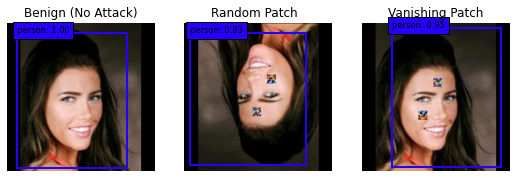

In [148]:
fpath = 'C:/Users/admin/Desktop/celebaTest/test/img_align_celeba/000027.jpg'
input_img = Image.open(fpath)
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)

# Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
rois = extract_roi(detections_query,detector.classes.index(SOURCE_CLASS),  x_meta, min_size =MIN_ROI_SIZE, patch_size = PATCH_SIZE)
landmarks = fr.face_landmarks((np.array(x_query.squeeze(0)*255).astype(int)).astype('uint8'))
# Apply adversarial patch to each of the rois
x_adv, x_rand = x_query.copy(), x_query.copy()


# forehead
patch_rand = np.reshape(headpatch.copy(), newshape=(headpatch.shape[0]*headpatch.shape[1]*headpatch.shape[2], headpatch.shape[3]))
np.random.shuffle(patch_rand)
patch_rand = np.reshape(patch_rand, newshape=headpatch.shape)
                        
x1,_ = landmarks[0]['right_eye'][len(landmarks[0]['right_eye'])-1]
x2, _ = landmarks[0]['left_eye'][0]
xmin = x1 + int((x2-x1)/2)
_,ymin = landmarks[0]['left_eyebrow'][len(landmarks[0]['left_eyebrow'])//2 +1]
if ymin>40:
    ymin-=40

xmax , ymax = xmin+ PATCH_SIZE[0], ymin+PATCH_SIZE[1]
x_adv[:, ymin:ymax, xmin:xmax, :] = headpatch
x_rand[:, ymin:ymax, xmin:xmax, :] = patch_rand


# left cheek 
patch_rand = np.reshape(cheekpatch.copy(), newshape=(cheekpatch.shape[0]*cheekpatch.shape[1]*cheekpatch.shape[2], cheekpatch.shape[3]))
np.random.shuffle(patch_rand)
patch_rand = np.reshape(patch_rand, newshape=cheekpatch.shape)
                        
xmin,_ = landmarks[0]['left_eye'][0]
_ , ymin = landmarks[0]['nose_bridge'][len(landmarks[0]['nose_bridge'])//2]

xmax , ymax = xmin+ PATCH_SIZE[0], ymin+PATCH_SIZE[1]
x_adv[:, ymin:ymax, xmin:xmax, :] = cheekpatch
x_rand[:, ymin:ymax, xmin:xmax, :] = patch_rand

 
# Basic Defense Methods for Illustration purposes 
'''
###########################################################################################################
#IMAGE TRANSLATION
img = x_adv.squeeze(0)
height, width = img.shape[:2]
shift_height, shift_width = 50 , 50 
T = np.float32([[1, 0, shift_width], [0, 1, shift_height]])
translated = cv2.warpAffine(img, T, (width, height))

translated = np.expand_dims(translated,axis = 0)


##########################################################################################################
#IMAGE WARPING
scale_percent = 75 
final = int((scale_percent/100)*416)
pts1 = np.float32([[0, 0], [0, 416], [416, 0], [416, 416]])
pts2 = np.float32([[0, 0], [0, final], [final, 0], [final, final]])
      
# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(pts1, pts2)
warped = cv2.warpPerspective(img, matrix, (416, 416))
warped = np.expand_dims(warped,axis=0)

########################################################################################################
#IMAGE ROTATION
img = x_adv.squeeze(0)
image_center = tuple(np.array(img.shape[1::-1]) / 2)
angle = 180
rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
rotated = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
rotated = np.expand_dims(rotated,axis = 0)
'''

# Illustration 

detections_adv = detector.detect(x_adv, conf_threshold=detector.confidence_thresh_default)
detections_rand = detector.detect(rotated, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'Random Patch  ': (x_rand, detections_adv, detector.model_img_size, detector.classes),
                      'Vanishing Patch': (x_adv, detections_rand, detector.model_img_size, detector.classes)})

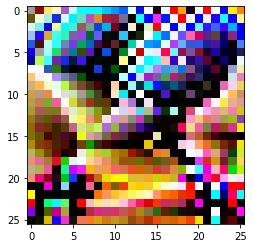

In [11]:
plt.imshow(cheekpatch.squeeze(0))

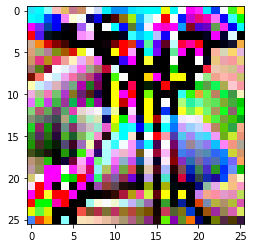

In [241]:
plt.imshow(headpatch.squeeze(0))

Pretrained Patch

In [7]:
headpatch = np.array([[[[1.65516724e-01, 8.82791494e-01, 9.76717158e-01],
         [1.89363994e-02, 9.90369037e-01, 9.93451884e-01],
         [5.46620203e-01, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 7.45424841e-01, 7.42089886e-01],
         [9.04800042e-01, 7.37317211e-01, 4.07386693e-01],
         [7.77736972e-01, 4.71281643e-01, 5.61425212e-01],
         [8.06464798e-01, 5.52051884e-01, 3.90127399e-01],
         [9.97944691e-01, 9.92381994e-01, 9.93600301e-01],
         [7.99419418e-01, 8.47457254e-01, 1.00000000e+00],
         [1.02095069e-04, 9.38613570e-01, 9.82481643e-01],
         [1.58077364e-02, 5.77803256e-01, 9.83681390e-01],
         [2.08636470e-02, 5.86221935e-01, 1.00000000e+00],
         [2.43208499e-02, 8.91538320e-01, 9.99352510e-01],
         [6.38125995e-02, 9.45606897e-01, 9.96160385e-01],
         [0.00000000e+00, 1.00000000e+00, 9.93308228e-01],
         [3.31620476e-03, 1.00000000e+00, 1.00000000e+00],
         [9.53314992e-01, 1.00000000e+00, 1.76346894e-02],
         [0.00000000e+00, 9.86918912e-01, 1.00000000e+00],
         [9.99146558e-01, 1.00000000e+00, 1.00000000e+00],
         [9.94569547e-01, 3.26976692e-03, 9.85997130e-01],
         [9.94493720e-01, 1.43406533e-01, 1.00000000e+00],
         [4.62089329e-03, 9.28682011e-01, 1.00000000e+00],
         [2.92821426e-02, 2.34220132e-01, 9.85556167e-01],
         [9.57784877e-01, 9.99463526e-01, 1.00000000e+00],
         [2.41588713e-01, 9.73929881e-01, 1.15156484e-01],
         [9.99307134e-01, 9.38046321e-01, 2.33486192e-03]],

        [[0.00000000e+00, 9.96845023e-01, 1.00000000e+00],
         [5.84912742e-03, 9.39726440e-01, 1.00000000e+00],
         [0.00000000e+00, 2.97683759e-01, 1.00000000e+00],
         [2.72614691e-02, 0.00000000e+00, 9.93748946e-01],
         [9.75533120e-01, 5.33306535e-01, 9.83561331e-01],
         [9.92797380e-01, 9.98165161e-01, 8.35348778e-01],
         [9.57367809e-01, 9.87803397e-01, 9.81613995e-01],
         [4.32193824e-02, 1.22233736e-03, 3.57276653e-01],
         [4.39926563e-03, 0.00000000e+00, 8.72979978e-01],
         [0.00000000e+00, 3.06562637e-03, 1.97483854e-02],
         [3.19865131e-01, 4.45067039e-04, 4.47638886e-04],
         [5.82204278e-01, 4.46373689e-01, 4.13758757e-02],
         [6.53146326e-01, 9.43576261e-01, 6.37450909e-02],
         [6.06593576e-02, 7.04959062e-01, 9.80948533e-01],
         [6.36877790e-01, 9.95716012e-01, 9.99924878e-01],
         [1.00000000e+00, 1.00000000e+00, 9.99192854e-01],
         [1.00000000e+00, 0.00000000e+00, 3.57149867e-03],
         [1.00000000e+00, 9.98764214e-01, 1.00000000e+00],
         [4.58160893e-03, 1.03367498e-01, 1.00000000e+00],
         [7.77766724e-01, 0.00000000e+00, 8.21145550e-01],
         [9.27482049e-01, 4.65339800e-02, 4.63401320e-01],
         [9.44628603e-01, 1.41866012e-02, 7.35251005e-01],
         [9.95215446e-01, 4.40634823e-01, 9.80214806e-01],
         [5.51438129e-02, 4.34553786e-03, 9.94348998e-01],
         [2.20841231e-01, 9.99063516e-01, 9.99352798e-01],
         [0.00000000e+00, 1.00000000e+00, 3.54037751e-03]],

        [[9.76494971e-01, 3.20432801e-03, 1.00000000e+00],
         [4.62513703e-01, 1.80704569e-01, 9.95834145e-01],
         [1.32198224e-03, 2.59535644e-01, 6.52162949e-01],
         [0.00000000e+00, 0.00000000e+00, 9.73870747e-01],
         [9.96194221e-03, 1.15569378e-02, 8.48570581e-02],
         [4.19934076e-02, 0.00000000e+00, 1.32787688e-02],
         [6.44261298e-01, 3.58937484e-01, 9.70239999e-01],
         [9.45330689e-01, 9.62312482e-01, 9.72712305e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.87687312e-01, 1.00000000e+00, 9.98081638e-01],
         [1.42539595e-02, 1.00000000e+00, 9.98467806e-01],
         [2.79558601e-03, 5.70980653e-02, 1.00000000e+00],
         [3.58295521e-01, 4.95772946e-01, 1.76299197e-01],
         [0.00000000e+00, 5.39854781e-01, 9.82972329e-01],
         [9.89582039e-01, 9.30634959e-01, 1.00000000e+00],
         [9.92292153e-01, 8.56973929e-04, 9.75612358e-01],
         [1.00000000e+00, 7.42643606e-04, 7.81776358e-01],
         [9.81661941e-01, 0.00000000e+00, 9.90494323e-01],
         [3.73429502e-02, 6.20086184e-01, 9.94071835e-01],
         [5.20726886e-01, 3.16487634e-02, 1.13835733e-01],
         [2.96405161e-01, 0.00000000e+00, 8.36629174e-01],
         [4.14184347e-01, 0.00000000e+00, 7.63533977e-01],
         [3.84399302e-01, 6.33877827e-01, 3.13397137e-01],
         [1.00000000e+00, 1.55053756e-01, 9.37107892e-01],
         [0.00000000e+00, 1.11472071e-03, 9.62236382e-01],
         [1.05565817e-02, 9.99229760e-01, 1.00000000e+00]],

        [[1.00000000e+00, 0.00000000e+00, 3.52534035e-02],
         [3.09666854e-01, 9.08555611e-02, 9.49048010e-01],
         [4.36938301e-03, 7.29717013e-02, 1.29122859e-01],
         [0.00000000e+00, 2.68851622e-02, 3.89068531e-02],
         [0.00000000e+00, 0.00000000e+00, 1.03260420e-02],
         [0.00000000e+00, 0.00000000e+00, 1.48735596e-02],
         [9.75669514e-01, 5.57674412e-01, 9.84956301e-01],
         [9.87485045e-01, 6.97371776e-01, 9.92339362e-01],
         [0.00000000e+00, 0.00000000e+00, 1.13606664e-02],
         [0.00000000e+00, 0.00000000e+00, 1.58658018e-03],
         [0.00000000e+00, 1.88770383e-02, 2.03614531e-02],
         [0.00000000e+00, 4.82854643e-03, 1.24134968e-01],
         [2.17747011e-01, 9.98657785e-01, 1.00000000e+00],
         [7.17282074e-03, 7.92454523e-01, 9.99162327e-01],
         [2.01941771e-03, 9.86324719e-01, 9.98673240e-01],
         [7.22412008e-01, 7.44569818e-01, 1.00000000e+00],
         [7.79631162e-02, 0.00000000e+00, 9.69243591e-01],
         [9.85317661e-01, 9.99857361e-01, 9.97325169e-01],
         [3.45231203e-03, 0.00000000e+00, 6.88990823e-03],
         [0.00000000e+00, 0.00000000e+00, 8.20664733e-03],
         [0.00000000e+00, 0.00000000e+00, 3.76489040e-03],
         [4.25165272e-03, 0.00000000e+00, 1.23400928e-01],
         [9.56425290e-01, 0.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.90535029e-01],
         [8.66224707e-01, 9.84675840e-01, 1.00000000e+00],
         [1.56066404e-03, 0.00000000e+00, 1.15187257e-03]],

        [[8.17384341e-01, 6.77171753e-01, 5.78053116e-01],
         [9.85242320e-01, 5.45892937e-01, 8.31311170e-02],
         [8.70167554e-01, 4.04535615e-02, 2.60469961e-02],
         [5.18629377e-01, 9.22360268e-05, 6.51770557e-03],
         [2.63396181e-01, 2.16721275e-02, 1.08735327e-02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [2.80881533e-03, 0.00000000e+00, 1.90882206e-02],
         [1.72438740e-05, 0.00000000e+00, 5.22061193e-03],
         [1.92935377e-02, 2.76337913e-03, 8.74644611e-04],
         [6.03561648e-02, 6.13305537e-03, 3.18037418e-02],
         [4.60405260e-01, 5.11061610e-03, 7.18497153e-03],
         [1.00000000e+00, 3.51035967e-04, 0.00000000e+00],
         [8.81080151e-01, 1.98779320e-01, 5.71751640e-02],
         [2.28642301e-01, 4.40042866e-02, 1.00000000e+00],
         [3.43297232e-01, 9.65718240e-01, 5.97547601e-01],
         [3.75436626e-01, 8.07819932e-04, 9.86017692e-01],
         [3.79738754e-01, 7.13770278e-04, 1.30379689e-01],
         [7.48467016e-01, 9.83381828e-01, 9.93145118e-01],
         [9.98798286e-01, 6.31628558e-04, 2.47725295e-01],
         [9.86075014e-01, 0.00000000e+00, 6.29986942e-01],
         [9.92575285e-01, 1.89970343e-02, 5.61185596e-02],
         [0.00000000e+00, 0.00000000e+00, 1.01362018e-02],
         [0.00000000e+00, 0.00000000e+00, 5.37938728e-03],
         [0.00000000e+00, 0.00000000e+00, 8.15807197e-02],
         [7.23864181e-02, 6.61851856e-02, 1.79147407e-01],
         [9.62015147e-01, 6.83468603e-01, 2.64388770e-01]],

        [[8.66471353e-01, 6.28053144e-01, 4.78674195e-01],
         [6.19698314e-01, 6.98747731e-01, 4.84232721e-01],
         [7.03925567e-01, 5.00292070e-01, 6.09532852e-01],
         [4.91730621e-01, 5.61048041e-01, 8.22942340e-02],
         [6.44138934e-01, 3.46658662e-01, 0.00000000e+00],
         [8.57026247e-01, 7.65275269e-02, 2.40338593e-02],
         [9.42471732e-01, 9.63583599e-01, 1.10302128e-01],
         [9.66933856e-01, 9.76799417e-01, 9.98773352e-01],
         [0.00000000e+00, 0.00000000e+00, 9.05417763e-03],
         [0.00000000e+00, 0.00000000e+00, 1.67100018e-03],
         [1.00000000e+00, 9.94084136e-01, 1.23558427e-02],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 6.17360687e-01, 1.00000000e+00],
         [5.55890748e-03, 1.46816159e-03, 4.18917683e-03],
         [2.74992605e-02, 9.74740589e-01, 9.27327262e-01],
         [4.91351515e-01, 2.88678238e-02, 9.95721864e-01],
         [0.00000000e+00, 0.00000000e+00, 9.15579050e-03],
         [3.90767020e-01, 9.15148102e-01, 5.96094872e-01],
         [9.90213331e-01, 1.25466430e-02, 9.87129352e-01],
         [4.84938791e-05, 0.00000000e+00, 0.00000000e+00],
         [9.98374848e-01, 0.00000000e+00, 9.55185842e-01],
         [2.21937848e-03, 0.00000000e+00, 3.85986606e-03],
         [9.94757417e-01, 7.08566538e-01, 6.21295258e-01],
         [8.45613683e-01, 8.40311507e-01, 7.14720379e-01],
         [9.84144436e-01, 8.40919011e-01, 4.20541960e-01],
         [9.00919547e-01, 7.14070451e-01, 8.60863953e-01]],

        [[8.06828979e-01, 5.93965461e-01, 4.07651542e-01],
         [9.02232603e-01, 2.01081490e-01, 5.12935373e-01],
         [7.31563635e-01, 5.60362447e-01, 8.82626805e-02],
         [9.38203983e-01, 2.38673763e-01, 4.59986172e-01],
         [9.38069804e-01, 6.33048214e-01, 6.00926855e-01],
         [9.94097811e-01, 9.50185457e-01, 7.44413923e-01],
         [9.14052378e-01, 6.90401475e-01, 9.94624907e-01],
         [9.49198024e-01, 6.46008163e-01, 6.14750929e-01],
         [9.39727573e-01, 3.48627338e-01, 9.88411724e-01],
         [0.00000000e+00, 0.00000000e+00, 6.26860687e-03],
         [0.00000000e+00, 0.00000000e+00, 2.60345157e-02],
         [2.22128960e-01, 2.86691647e-05, 1.00000000e+00],
         [9.71044093e-01, 0.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 5.10279636e-03],
         [9.77195235e-01, 9.99686527e-01, 2.00422025e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 9.96813346e-01, 9.79319832e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 9.97151049e-01],
         [0.00000000e+00, 2.17554555e-03, 1.20870993e-01],
         [9.27859346e-01, 7.81808486e-01, 4.96922924e-01],
         [9.23749777e-01, 6.46662246e-01, 6.83235701e-01],
         [9.74715996e-01, 6.00811529e-01, 6.11010869e-01],
         [9.16144248e-01, 8.09984379e-01, 4.90542905e-01]],

        [[6.47446035e-01, 4.69222463e-01, 4.67737167e-01],
         [3.47196290e-01, 4.86374848e-01, 8.30860168e-02],
         [5.18921080e-01, 1.71618975e-02, 1.93039579e-01],
         [9.96284189e-01, 9.93837468e-01, 1.00000000e+00],
         [8.98989503e-01, 9.52799456e-01, 9.86404643e-01],
         [9.04125460e-01, 7.69138506e-01, 9.76575096e-01],
         [9.92494461e-01, 3.99467092e-01, 9.31512145e-01],
         [6.15478178e-01, 6.77094753e-01, 5.51958920e-01],
         [6.32248531e-01, 4.49511610e-01, 3.73045606e-01],
         [7.63890479e-01, 2.53498023e-02, 2.05690812e-01],
         [8.48422114e-01, 9.98877809e-01, 1.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.87051989e-02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.73170189e-03, 7.18236191e-03],
         [0.00000000e+00, 0.00000000e+00, 8.16804875e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 8.05407669e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [4.10740962e-03, 0.00000000e+00, 0.00000000e+00],
         [2.22704874e-03, 0.00000000e+00, 0.00000000e+00],
         [9.98030370e-01, 1.29702315e-01, 2.42484201e-01],
         [9.28701989e-01, 7.78938328e-01, 6.94025373e-01],
         [9.09785051e-01, 7.51044100e-01, 5.97818880e-01],
         [8.20324031e-01, 7.70239511e-01, 5.65075212e-01],
         [9.51476014e-01, 5.99870973e-01, 7.30617638e-01]],

        [[4.76238703e-01, 7.13367814e-02, 0.00000000e+00],
         [9.98647643e-01, 4.56580621e-01, 4.07705001e-01],
         [9.96793426e-01, 9.96134905e-01, 9.98233243e-01],
         [8.00189938e-01, 9.38377429e-01, 9.90950760e-01],
         [9.38209680e-01, 6.47863499e-01, 9.32999167e-01],
         [9.60379980e-01, 4.32383534e-01, 6.58032653e-01],
         [6.67207763e-01, 4.76379269e-01, 5.32562612e-01],
         [7.47284728e-01, 2.55953335e-01, 4.53483227e-01],
         [4.92220253e-01, 0.00000000e+00, 5.47052108e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [2.69743262e-01, 9.92535221e-01, 0.00000000e+00],
         [9.94311376e-01, 9.98603397e-01, 9.83755998e-01],
         [1.50796464e-02, 0.00000000e+00, 0.00000000e+00],
         [2.24261312e-03, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 8.24010352e-01, 3.45920306e-03],
         [1.00000000e+00, 0.00000000e+00, 9.98560837e-01],
         [6.36612065e-04, 0.00000000e+00, 0.00000000e+00],
         [9.51261535e-01, 9.96239215e-01, 0.00000000e+00],
         [9.90282467e-01, 1.00000000e+00, 1.62167620e-03],
         [0.00000000e+00, 4.76013753e-03, 0.00000000e+00],
         [9.76354604e-01, 9.84726226e-01, 9.73896720e-01],
         [5.85356809e-01, 9.27750859e-01, 5.48929084e-01],
         [9.44611568e-01, 6.41853766e-01, 5.62352386e-01],
         [9.99805620e-01, 7.14269620e-01, 6.83034764e-01],
         [9.90453326e-01, 6.40641434e-01, 6.50802553e-01],
         [7.92388850e-01, 7.73058417e-01, 4.31612968e-01]],

        [[1.00000000e+00, 1.00000000e+00, 6.98562337e-01],
         [7.80758467e-01, 9.45017573e-01, 9.99085783e-01],
         [7.68121696e-01, 7.80700303e-01, 9.97558199e-01],
         [8.69138158e-01, 6.95271638e-01, 7.29481685e-01],
         [6.77701762e-01, 4.87614486e-01, 7.56482709e-01],
         [4.51278190e-01, 6.58894668e-01, 5.16589309e-01],
         [6.86686011e-01, 0.00000000e+00, 6.80229542e-01],
         [1.25443103e-01, 4.59196394e-01, 1.33235322e-01],
         [4.64731091e-01, 0.00000000e+00, 3.21765056e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.88697484e-01, 1.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 1.55610018e-03, 3.20858778e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.14179658e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 1.38062527e-03, 1.57837967e-02],
         [1.56879469e-02, 4.73925471e-03, 0.00000000e+00],
         [0.00000000e+00, 1.12554526e-02, 7.15248933e-03],
         [2.35525123e-03, 2.09121003e-03, 3.21657405e-03],
         [5.14787648e-02, 8.41217668e-01, 1.32368473e-01],
         [3.64620518e-01, 6.27324203e-01, 2.89289198e-01],
         [6.74297821e-02, 9.72979498e-01, 3.40901628e-01],
         [6.71928827e-01, 6.78285405e-01, 3.13890920e-01],
         [9.94067810e-01, 7.86173843e-01, 8.16879990e-01],
         [9.90887686e-01, 6.06207045e-01, 6.46194719e-01]],

        [[9.34348779e-01, 6.77148660e-01, 8.85076446e-01],
         [6.86421032e-01, 7.66056307e-01, 5.68651939e-01],
         [9.53045338e-01, 4.66867260e-01, 7.15650416e-01],
         [4.63537611e-01, 7.62235134e-01, 4.42081516e-01],
         [6.75843337e-01, 2.17931874e-01, 7.92603084e-01],
         [5.32264009e-01, 4.69369566e-01, 1.29664957e-01],
         [4.07787877e-01, 1.34633173e-01, 4.57523200e-01],
         [3.23154999e-01, 1.19137158e-01, 5.17015742e-02],
         [9.00855645e-02, 2.01098784e-03, 3.09634643e-01],
         [9.25285899e-03, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
         [9.70445907e-01, 0.00000000e+00, 9.66101161e-01],
         [9.99153825e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [4.55961688e-01, 1.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [8.28429422e-03, 0.00000000e+00, 5.43768647e-03],
         [1.44333879e-02, 0.00000000e+00, 5.30225260e-03],
         [1.91631241e-01, 1.00000000e+00, 9.46565750e-01],
         [2.01462256e-01, 9.83799658e-01, 3.62815586e-02],
         [9.28732504e-01, 6.31885215e-01, 2.07584633e-01],
         [3.72612225e-01, 9.81359537e-01, 2.89268685e-01],
         [7.34713800e-01, 5.06649836e-01, 3.83123281e-01],
         [2.28560211e-03, 9.53793545e-01, 2.70270181e-01],
         [2.54383400e-01, 6.00388690e-01, 2.75869114e-01],
         [9.72715020e-01, 9.53596715e-01, 7.47827978e-01]],

        [[8.94896318e-01, 4.53534770e-01, 9.94225478e-01],
         [3.74831828e-01, 9.44141490e-01, 3.42060840e-01],
         [7.86485801e-01, 2.47641565e-01, 9.16686988e-01],
         [2.47979149e-01, 7.12010057e-01, 2.83541949e-01],
         [6.14071183e-01, 2.13909071e-01, 6.04687385e-01],
         [2.41941429e-02, 7.12806322e-01, 3.23615337e-01],
         [6.31378665e-01, 3.02716058e-02, 6.41336197e-01],
         [7.31999978e-02, 7.40235318e-01, 1.36894115e-01],
         [5.83070336e-01, 6.76241752e-03, 6.32153612e-01],
         [1.93857063e-03, 2.88053998e-04, 2.61319859e-03],
         [1.00000000e+00, 9.85554135e-01, 0.00000000e+00],
         [7.69739689e-01, 0.00000000e+00, 1.05071580e-04],
         [1.00000000e+00, 6.57347374e-02, 1.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.05178182e-02],
         [1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.93796484e-01, 1.00000000e+00, 9.97625080e-01],
         [0.00000000e+00, 2.54157415e-03, 0.00000000e+00],
         [6.86598335e-01, 9.91565563e-01, 4.86038824e-01],
         [1.55590349e-01, 9.49620394e-01, 6.44019132e-01],
         [4.01008527e-01, 1.00000000e+00, 7.08203227e-01],
         [4.95534287e-01, 8.86014710e-01, 3.56727102e-01],
         [3.62605450e-01, 9.00279279e-01, 3.48103297e-01],
         [5.16887873e-01, 6.73152942e-01, 1.99864385e-01],
         [2.82207573e-01, 6.76577575e-01, 2.44959793e-01],
         [0.00000000e+00, 7.96350784e-01, 0.00000000e+00]],

        [[5.19888958e-01, 8.32068224e-01, 4.85575546e-01],
         [7.25059512e-01, 3.51187739e-01, 4.54239626e-01],
         [3.91102651e-01, 6.61629204e-01, 3.32488323e-01],
         [4.74354150e-01, 2.31688129e-01, 4.43488708e-01],
         [3.45633162e-01, 6.54536742e-01, 4.12524284e-01],
         [8.88459006e-01, 2.47515571e-01, 7.13478619e-01],
         [8.98990320e-01, 8.43337984e-01, 8.09784357e-01],
         [9.44799740e-01, 8.85319103e-01, 9.48062526e-01],
         [9.82080412e-01, 9.67318687e-01, 9.70449480e-01],
         [4.44661652e-01, 6.52343279e-01, 9.93281284e-01],
         [9.33772429e-01, 9.99467900e-01, 6.10672541e-01],
         [0.00000000e+00, 7.95579411e-03, 1.11308321e-03],
         [9.89001063e-01, 8.68513992e-01, 1.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 9.85954212e-01, 0.00000000e+00],
         [9.44158913e-03, 0.00000000e+00, 0.00000000e+00],
         [7.98139724e-03, 1.88264867e-01, 9.66441382e-01],
         [1.15545726e-02, 8.55964853e-03, 0.00000000e+00],
         [9.99815423e-01, 1.00000000e+00, 1.40601119e-01],
         [4.55688274e-01, 9.57774695e-01, 3.49302569e-01],
         [9.05841159e-01, 1.00000000e+00, 1.65553222e-01],
         [4.39880416e-01, 9.76939260e-01, 4.37660669e-01],
         [6.78104629e-01, 5.94872024e-01, 3.60654056e-01],
         [8.44990517e-02, 9.89214903e-01, 1.32889065e-01],
         [5.59690747e-01, 3.80894679e-01, 4.33580138e-01],
         [2.54652440e-03, 9.69517994e-01, 1.40759971e-02]],

        [[5.13757162e-01, 5.82472483e-01, 4.48627829e-01],
         [3.82946980e-01, 4.95302027e-01, 4.03721489e-01],
         [3.65248181e-01, 3.60080237e-01, 4.26323523e-01],
         [2.25646797e-01, 3.07840245e-01, 3.09433376e-01],
         [6.98502837e-01, 6.45030394e-01, 4.93265615e-01],
         [6.15574865e-02, 7.85481612e-01, 4.36005119e-01],
         [7.35927799e-01, 7.48456613e-01, 5.67692824e-01],
         [6.75989079e-01, 9.38094116e-01, 7.83373754e-01],
         [8.60301692e-01, 8.86591920e-01, 7.05701861e-01],
         [4.88783023e-03, 6.13295031e-03, 3.41775031e-01],
         [1.00000000e+00, 9.99857714e-01, 9.74206373e-03],
         [1.54829243e-02, 9.55794928e-01, 3.72422161e-04],
         [9.98862537e-01, 4.86947047e-01, 9.99788734e-01],
         [4.40983567e-05, 4.89671013e-03, 3.77201741e-01],
         [9.91584172e-01, 9.95762738e-01, 2.21726013e-03],
         [6.86386276e-01, 0.00000000e+00, 0.00000000e+00],
         [7.91939478e-01, 9.99740918e-01, 1.00000000e+00],
         [1.08235587e-02, 6.11169804e-01, 1.00000000e+00],
         [9.48327402e-01, 9.16592116e-01, 1.00000000e+00],
         [9.75151822e-01, 9.48834912e-01, 9.99630223e-01],
         [9.36596518e-01, 9.11176672e-01, 9.77369468e-01],
         [7.18049810e-01, 9.12979241e-01, 1.05435000e-01],
         [3.02046874e-01, 9.52131167e-01, 2.50791959e-01],
         [4.75511675e-01, 6.20287164e-01, 2.36899679e-01],
         [2.35899981e-01, 7.66603691e-01, 1.82785747e-02],
         [5.70347197e-03, 6.31941252e-01, 9.88617149e-02]],

        [[1.28814566e-01, 8.37973209e-01, 1.50683433e-01],
         [5.67404051e-01, 1.37568177e-01, 3.97863508e-01],
         [7.08068745e-02, 5.89530065e-01, 4.81266579e-02],
         [2.59366454e-01, 9.34525596e-02, 2.53090478e-01],
         [4.02933254e-01, 5.74719344e-01, 5.40489056e-01],
         [5.33665646e-01, 1.88354136e-01, 4.01483036e-01],
         [6.85986909e-01, 5.72541373e-01, 7.04918304e-01],
         [8.05598924e-01, 7.55949326e-01, 7.68936705e-01],
         [6.08654267e-01, 9.12148802e-01, 8.25011825e-01],
         [9.28628330e-01, 3.76412575e-01, 8.10978361e-01],
         [6.69812685e-01, 9.65126407e-01, 5.79906127e-03],
         [3.14607848e-03, 9.99576941e-01, 9.80459529e-01],
         [1.16392879e-01, 9.97692257e-01, 9.96823655e-01],
         [0.00000000e+00, 2.60112311e-02, 9.90622841e-01],
         [2.95620784e-03, 9.60330901e-01, 8.10027273e-01],
         [5.56862632e-03, 7.47129531e-03, 3.90590893e-02],
         [4.02290178e-02, 1.00000000e+00, 1.00000000e+00],
         [2.46396584e-02, 4.58911081e-01, 9.96815043e-01],
         [7.99010223e-01, 6.31246248e-01, 9.96591821e-01],
         [6.12820516e-01, 8.18552415e-01, 9.91282678e-01],
         [7.58967421e-01, 8.57207347e-01, 9.93551440e-01],
         [9.97121304e-01, 6.91727285e-01, 9.66857846e-01],
         [7.22894160e-01, 5.29760068e-01, 3.74977354e-01],
         [3.63014987e-01, 7.86581807e-01, 8.90734035e-03],
         [1.75481981e-01, 6.54780982e-01, 2.80033168e-01],
         [9.68039503e-01, 6.82742639e-01, 5.62410997e-01]],

        [[2.09485966e-01, 5.48850203e-01, 1.66907715e-01],
         [3.42034028e-01, 1.66975682e-01, 3.81036200e-01],
         [1.49619247e-01, 4.22305304e-01, 6.56896312e-02],
         [1.48688926e-01, 4.15759317e-02, 2.25569526e-01],
         [3.11693301e-01, 6.88393005e-01, 1.43925207e-01],
         [1.01733266e-01, 3.71647687e-01, 1.74986197e-01],
         [5.03914165e-01, 7.10116953e-01, 3.48340820e-01],
         [6.06227149e-01, 9.97594145e-01, 6.63543396e-01],
         [9.82605143e-01, 5.65127895e-01, 8.09471081e-01],
         [1.42207958e-01, 4.09380975e-02, 5.56450913e-02],
         [6.21225553e-01, 9.99728733e-01, 9.99624473e-01],
         [5.85550093e-03, 9.99875758e-01, 9.98720838e-01],
         [9.85686614e-01, 8.90991466e-01, 7.97949294e-01],
         [2.00557755e-02, 4.30220412e-03, 4.20583294e-02],
         [1.00000000e+00, 9.95509268e-01, 9.98381754e-01],
         [9.94919394e-01, 3.25471308e-04, 4.75770494e-02],
         [9.99073281e-01, 6.01887438e-01, 6.56343358e-01],
         [3.06582522e-01, 2.31093407e-01, 6.75180460e-01],
         [3.16093083e-01, 7.91151658e-01, 9.29985808e-01],
         [6.39694160e-01, 5.30289205e-01, 9.69964483e-01],
         [3.77997014e-01, 8.10159523e-01, 9.86391997e-01],
         [2.47457550e-01, 8.62761159e-01, 9.95013738e-01],
         [9.39847450e-01, 6.06170924e-01, 9.74284362e-01],
         [4.31073097e-01, 6.83085077e-01, 1.04731788e-01],
         [7.91074046e-01, 9.19972424e-01, 1.82720489e-01],
         [9.16393345e-01, 5.87866748e-01, 4.60963913e-01]],

        [[1.21239648e-01, 5.91042530e-01, 2.20084592e-02],
         [2.93452747e-01, 1.72826179e-01, 1.54379787e-01],
         [1.18007259e-02, 3.17751896e-01, 1.31918350e-03],
         [3.26394721e-02, 1.07533975e-01, 2.21665935e-02],
         [3.27629265e-01, 2.88548607e-01, 4.59335744e-01],
         [2.44029584e-01, 1.14307049e-02, 1.35116398e-01],
         [6.08418852e-01, 4.15895508e-01, 7.27873909e-01],
         [9.61937815e-01, 9.99942818e-01, 6.92179277e-01],
         [3.99988146e-01, 9.71392184e-03, 3.00166364e-01],
         [7.35542226e-01, 9.99968931e-01, 9.99757066e-01],
         [2.05687283e-01, 9.89502832e-01, 9.98689891e-01],
         [9.50053402e-01, 9.89362746e-01, 9.95651101e-01],
         [9.85838023e-01, 5.88688489e-01, 9.77195078e-01],
         [2.06972518e-01, 4.09711610e-01, 9.99347107e-01],
         [4.34954681e-02, 9.80996566e-01, 9.99939881e-01],
         [2.64789519e-01, 2.33056187e-03, 3.29286094e-01],
         [9.90343461e-01, 9.95996384e-01, 1.00000000e+00],
         [4.62241112e-01, 1.71615959e-02, 4.07991601e-01],
         [4.19505818e-01, 5.38911235e-01, 9.58666222e-01],
         [6.19299498e-01, 5.23691731e-01, 5.89123193e-01],
         [5.01897616e-01, 6.11884710e-01, 8.63201470e-01],
         [5.68982803e-01, 4.67013231e-01, 9.51539344e-01],
         [5.26975427e-02, 7.49719999e-01, 1.00000000e+00],
         [9.96474156e-01, 5.17149034e-01, 9.76332415e-01],
         [9.60016967e-01, 5.88579004e-01, 5.00082306e-01],
         [6.75501403e-01, 6.57873642e-01, 6.03711749e-01]],

        [[2.57857894e-01, 3.12709017e-01, 1.00456448e-01],
         [9.41537377e-02, 2.15860454e-01, 4.46663381e-02],
         [1.17542160e-01, 8.22447712e-02, 4.45846868e-02],
         [3.52567714e-03, 1.60534066e-02, 2.88662943e-03],
         [1.38309239e-01, 5.96710406e-01, 1.82869851e-02],
         [0.00000000e+00, 1.10483987e-01, 9.35206874e-02],
         [2.41211554e-01, 9.44870266e-01, 2.83685973e-02],
         [9.85396276e-01, 6.27258814e-01, 9.82643696e-01],
         [1.79916249e-01, 2.04944111e-02, 4.54424786e-01],
         [6.90112692e-01, 1.00000000e+00, 1.00000000e+00],
         [9.32719128e-01, 7.17136990e-01, 9.98144518e-01],
         [9.33095082e-01, 7.16836887e-01, 7.93783756e-01],
         [9.65131501e-01, 5.78611854e-01, 9.59053557e-01],
         [4.37280085e-01, 3.50162288e-01, 8.47637477e-02],
         [9.68207795e-01, 9.66733802e-01, 9.97484321e-01],
         [6.03971761e-01, 3.36010894e-03, 1.97473524e-01],
         [9.88244787e-01, 7.19470534e-01, 9.77826268e-01],
         [4.45704030e-01, 7.25068268e-04, 1.00008845e-01],
         [2.58529449e-01, 5.00455012e-01, 9.33175166e-01],
         [3.62922598e-01, 3.93264711e-01, 9.05015579e-01],
         [4.20365640e-01, 5.31190298e-01, 6.93993471e-01],
         [3.25315702e-01, 5.46371371e-01, 7.03127304e-01],
         [1.84006628e-01, 4.06122490e-01, 9.61842573e-01],
         [6.76469387e-02, 5.25049885e-01, 1.00000000e+00],
         [8.13897205e-01, 8.26004246e-01, 2.09051140e-01],
         [8.37597100e-01, 5.96289788e-01, 4.24713429e-01]],

        [[7.31327726e-01, 5.84184453e-01, 4.76615072e-01],
         [5.69534609e-01, 5.04376899e-01, 3.04548158e-01],
         [1.51616227e-01, 7.40725615e-01, 4.76161956e-02],
         [2.07135978e-02, 6.21904165e-03, 3.06387543e-02],
         [5.73079108e-02, 8.96301229e-03, 2.10066736e-01],
         [4.40342369e-01, 4.07187035e-05, 2.03870528e-01],
         [1.00000000e+00, 6.65012108e-01, 9.80342815e-01],
         [8.09635561e-01, 1.31802952e-02, 9.77050180e-01],
         [4.59841044e-01, 9.83531817e-01, 4.91424591e-01],
         [6.82487099e-01, 9.93908694e-01, 9.84570455e-01],
         [9.65707415e-01, 4.54775090e-01, 9.75160692e-01],
         [5.55968266e-01, 6.97327923e-01, 7.93016031e-01],
         [7.88941488e-01, 3.16976313e-01, 9.42686160e-01],
         [5.69685002e-02, 3.51619526e-01, 6.27448889e-01],
         [8.90495434e-01, 8.50582983e-01, 9.69845366e-01],
         [8.50493374e-03, 3.18885688e-03, 1.52058826e-01],
         [9.86376364e-01, 9.22830492e-01, 9.73959359e-01],
         [5.38822676e-01, 0.00000000e+00, 9.43793508e-04],
         [5.43280813e-01, 1.80237575e-01, 7.57227044e-01],
         [1.74731660e-01, 4.32114272e-01, 6.91109895e-01],
         [4.98194299e-01, 4.04228805e-01, 6.00740028e-01],
         [3.12167340e-01, 3.58736161e-01, 8.51783989e-01],
         [3.06473574e-01, 4.39477316e-01, 6.85491755e-01],
         [7.74275069e-03, 4.61299202e-01, 9.97976144e-01],
         [4.66424676e-01, 4.00564692e-01, 9.84661199e-01],
         [9.99197365e-01, 6.27803676e-01, 3.72778365e-01]],

        [[7.39841246e-01, 6.02830523e-01, 6.34840694e-01],
         [5.65411319e-01, 5.66243487e-01, 3.47492057e-01],
         [9.71711532e-01, 0.00000000e+00, 9.94354281e-01],
         [9.99784677e-01, 8.60828906e-04, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.42506518e-01, 1.00000000e+00],
         [1.00000000e+00, 5.97182508e-01, 8.35726520e-01],
         [8.21761137e-01, 1.88058093e-02, 4.05059281e-01],
         [5.49434655e-01, 9.52760721e-01, 9.83256584e-01],
         [7.05777842e-01, 7.62982592e-01, 3.78708175e-01],
         [8.09842149e-01, 3.01032808e-01, 8.99354798e-01],
         [4.51199448e-01, 6.50652404e-01, 2.63080348e-01],
         [8.69821131e-01, 2.73177518e-01, 3.17251093e-01],
         [1.02945103e-01, 1.64056394e-01, 3.40547895e-02],
         [8.92044796e-01, 7.85963685e-01, 6.85275770e-01],
         [2.96334049e-01, 2.19462747e-02, 8.99232364e-02],
         [6.55861068e-01, 7.20520641e-01, 9.95528965e-01],
         [1.59852940e-01, 0.00000000e+00, 1.24820136e-03],
         [5.22620185e-01, 3.04158395e-01, 3.06246120e-01],
         [5.57361450e-03, 1.76995072e-01, 7.25241412e-01],
         [2.53223220e-01, 5.03501304e-01, 3.33275575e-01],
         [2.91583972e-01, 1.82009590e-01, 7.95416432e-01],
         [1.59500067e-01, 5.91559325e-01, 1.21051411e-01],
         [6.00625019e-03, 1.92663594e-01, 9.92508317e-01],
         [4.10277480e-01, 5.68517158e-01, 9.96098280e-01],
         [1.47989010e-02, 7.40502245e-01, 0.00000000e+00]],

        [[8.36330100e-01, 7.95811960e-01, 4.58490046e-01],
         [1.00000000e+00, 9.86391588e-01, 9.98456045e-01],
         [1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 8.50806478e-04, 1.00000000e+00],
         [0.00000000e+00, 9.84857830e-01, 2.95811605e-02],
         [1.91575012e-03, 8.12380375e-01, 0.00000000e+00],
         [9.86245569e-01, 5.01970099e-03, 3.53437512e-03],
         [7.25260656e-01, 2.69853091e-03, 9.86426905e-01],
         [1.74246816e-01, 9.97861440e-01, 4.66807297e-01],
         [6.85931349e-01, 2.91986228e-01, 4.66786724e-01],
         [4.87004866e-01, 3.90576489e-01, 6.51874689e-01],
         [5.83850788e-01, 1.87128668e-01, 3.10001991e-01],
         [4.49506824e-01, 9.79196922e-04, 8.59392505e-01],
         [8.35704585e-03, 7.12648752e-03, 1.32503642e-01],
         [7.43813006e-01, 6.21972788e-01, 9.40534012e-01],
         [2.31260067e-02, 1.36263718e-02, 2.90399178e-02],
         [2.98072122e-01, 8.90436972e-01, 7.99807977e-01],
         [4.56124262e-03, 7.23401083e-03, 4.57613590e-02],
         [8.39595557e-01, 6.49997912e-03, 2.29376006e-01],
         [1.31096924e-04, 6.56272809e-03, 5.43670542e-01],
         [2.06516610e-01, 2.77034564e-01, 2.76256027e-01],
         [7.44560965e-02, 1.68136684e-01, 6.79511221e-01],
         [1.28957201e-01, 3.54684859e-02, 6.00905279e-01],
         [4.63706569e-03, 2.89224940e-01, 9.94616259e-01],
         [9.60303994e-01, 7.28275980e-01, 5.79748360e-01],
         [9.98253884e-01, 9.74689879e-01, 7.79771614e-01]],

        [[9.99983095e-01, 8.74970722e-01, 9.96909613e-01],
         [9.94589097e-01, 0.00000000e+00, 6.81584820e-03],
         [1.00000000e+00, 0.00000000e+00, 9.95433654e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 9.76522687e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 1.05429829e-02, 9.98268088e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [6.23253639e-01, 2.88799102e-01, 6.84306331e-01],
         [5.74189782e-01, 2.54498102e-01, 2.13255784e-01],
         [3.77211918e-01, 2.79101875e-01, 3.30501213e-01],
         [1.26020713e-01, 5.76980293e-02, 4.22525380e-02],
         [6.51528191e-02, 4.18497023e-02, 3.38574548e-02],
         [2.75105259e-03, 2.17414561e-02, 7.08782265e-03],
         [5.79127417e-01, 6.73825169e-01, 2.59830514e-02],
         [3.61073291e-03, 2.71511485e-03, 0.00000000e+00],
         [6.65840992e-01, 6.91451144e-01, 6.68469729e-03],
         [1.16351771e-03, 3.64230261e-02, 4.66269259e-02],
         [1.13373176e-02, 5.21894865e-03, 4.45597532e-03],
         [0.00000000e+00, 0.00000000e+00, 2.04092260e-02],
         [1.92070076e-02, 3.38715375e-02, 5.05065247e-01],
         [5.53831832e-01, 7.42368901e-01, 6.21534848e-01],
         [8.97118798e-01, 6.79264662e-01, 9.06139838e-01],
         [9.48188745e-01, 9.56972136e-01, 4.47399480e-01],
         [9.62790275e-01, 7.56185459e-01, 5.05003894e-01],
         [9.94066872e-01, 5.96412568e-01, 7.66872030e-01]],

        [[9.96307038e-01, 3.83661257e-03, 9.98642796e-01],
         [9.97230986e-01, 4.99804155e-03, 0.00000000e+00],
         [1.00000000e+00, 9.99319639e-01, 1.78784675e-01],
         [9.84057669e-01, 0.00000000e+00, 1.43243605e-03],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.93662637e-01, 1.17426855e-03, 9.99492605e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 2.57532552e-03],
         [6.17124598e-03, 1.41584537e-02, 1.73976156e-03],
         [7.16341183e-02, 7.80472510e-03, 8.54033569e-04],
         [2.00465503e-01, 4.96959047e-02, 1.81633359e-02],
         [6.67450189e-01, 9.29254702e-02, 2.32330067e-01],
         [7.10678552e-01, 6.19660289e-01, 5.70240881e-02],
         [9.61032486e-01, 2.90408517e-01, 5.94370288e-01],
         [8.22943866e-01, 9.64819823e-01, 2.47319769e-01],
         [3.75483765e-01, 5.45791421e-03, 4.92281405e-02],
         [9.93159073e-01, 9.94990028e-01, 1.18001819e-02],
         [2.20769574e-03, 9.53988876e-03, 8.04470101e-03],
         [1.00000000e+00, 9.90617814e-01, 3.36135547e-02],
         [3.02927761e-03, 5.59063605e-03, 6.06591188e-04],
         [7.80270104e-01, 4.94172119e-01, 9.45165014e-01],
         [9.55765199e-01, 6.60172755e-01, 5.54320953e-01],
         [9.96165899e-01, 5.58814568e-01, 6.41839195e-01],
         [8.88324066e-01, 6.05781067e-01, 8.02487748e-01],
         [8.97385559e-01, 5.56731887e-01, 7.14094973e-01],
         [7.41470789e-01, 8.66695978e-01, 3.59097649e-01]],

        [[9.95289675e-01, 4.39673542e-02, 0.00000000e+00],
         [3.50853102e-03, 9.81232008e-01, 0.00000000e+00],
         [7.42854201e-04, 9.82774811e-01, 0.00000000e+00],
         [9.92231956e-01, 0.00000000e+00, 7.09918840e-01],
         [1.00000000e+00, 0.00000000e+00, 3.09540046e-04],
         [0.00000000e+00, 0.00000000e+00, 6.20288562e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [6.19901673e-01, 9.81965036e-01, 9.36534644e-01],
         [9.92415562e-01, 9.80654755e-01, 8.53934602e-01],
         [9.79187536e-01, 9.84475206e-01, 9.96188296e-01],
         [9.43203257e-01, 9.82068081e-01, 8.21896478e-01],
         [7.36080410e-01, 9.58223305e-01, 9.70732109e-01],
         [7.65625712e-01, 7.00155987e-01, 9.73462352e-01],
         [5.37608982e-01, 7.67719277e-01, 6.90764645e-01],
         [6.08235744e-01, 3.96430935e-01, 6.91656293e-01],
         [3.30456748e-02, 7.86553603e-03, 1.48169594e-02],
         [2.07519803e-01, 6.33541583e-01, 1.67399138e-01],
         [1.24161714e-02, 3.41449863e-02, 6.05534135e-03],
         [1.56015908e-02, 1.21626671e-01, 6.05209090e-01],
         [2.34210840e-03, 6.42774417e-03, 1.66609879e-02],
         [8.70768241e-01, 2.56302219e-01, 2.38046755e-02],
         [4.71592492e-01, 5.50727999e-01, 6.90495382e-01],
         [7.10881187e-01, 7.01696889e-01, 2.43325095e-01],
         [6.93899277e-01, 5.61312326e-01, 4.21714707e-01],
         [6.96840339e-01, 7.44150295e-01, 2.07013983e-01],
         [8.50591315e-01, 3.29590999e-01, 6.84328821e-01]],

        [[8.97039626e-01, 9.85981685e-01, 3.64816125e-03],
         [3.68939391e-01, 9.80442689e-01, 2.46298176e-01],
         [8.61630672e-01, 9.37641294e-01, 0.00000000e+00],
         [1.19958271e-03, 0.00000000e+00, 5.44821139e-03],
         [0.00000000e+00, 0.00000000e+00, 5.88608651e-03],
         [2.49944823e-02, 0.00000000e+00, 0.00000000e+00],
         [9.56798960e-01, 3.12426083e-01, 2.69822331e-01],
         [4.84540508e-01, 3.19770497e-01, 1.55747225e-01],
         [7.00693231e-01, 1.73069994e-01, 2.72905523e-01],
         [4.96648226e-01, 4.44290909e-01, 2.04259594e-01],
         [7.38752299e-01, 1.95628875e-01, 3.84730834e-01],
         [5.97076461e-01, 4.60866363e-01, 1.41735163e-01],
         [7.19469906e-01, 2.70923202e-01, 2.29338211e-01],
         [5.06135104e-01, 4.23095798e-01, 7.70754234e-02],
         [4.82010641e-01, 3.11154958e-01, 0.00000000e+00],
         [7.30394680e-02, 1.38557801e-02, 1.25734377e-02],
         [7.95629762e-01, 2.31525153e-01, 3.48005776e-01],
         [3.24667034e-01, 3.85887236e-01, 1.96985897e-01],
         [4.95117537e-01, 4.48732563e-01, 6.71787626e-02],
         [7.03246507e-03, 2.28897878e-01, 8.01995463e-01],
         [2.56217110e-02, 2.66996872e-02, 2.12925581e-02],
         [6.25215500e-01, 3.26338689e-01, 5.23623661e-02],
         [6.21243039e-01, 1.65962764e-01, 6.39045336e-01],
         [5.89217312e-01, 5.24643003e-01, 3.20671020e-01],
         [8.48905552e-01, 3.84612532e-01, 6.99995964e-01],
         [8.64021234e-01, 9.16900778e-01, 3.74831909e-01]],

        [[2.70839877e-01, 5.13351354e-01, 9.56264537e-01],
         [9.26745552e-01, 2.33434778e-01, 2.05230735e-02],
         [1.00000000e+00, 7.12363878e-01, 2.80120422e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [5.38341100e-01, 1.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.76864084e-01, 8.86693516e-01, 7.32062332e-01],
         [9.72461925e-01, 8.64051439e-01, 7.18566826e-01],
         [9.89237745e-01, 7.95420210e-01, 7.20824630e-01],
         [9.10345402e-01, 7.47034641e-01, 6.28990371e-01],
         [8.35369456e-01, 6.53225107e-01, 5.86392951e-01],
         [6.64496010e-01, 5.96864441e-01, 4.41280869e-01],
         [6.95481577e-01, 3.75673594e-01, 5.31458889e-01],
         [4.94728285e-01, 4.83480196e-01, 2.62270497e-01],
         [5.37895930e-01, 1.60424961e-01, 5.17575154e-01],
         [1.17255409e-01, 2.56300026e-02, 2.03444587e-02],
         [3.85050514e-01, 9.60494126e-01, 5.38922558e-03],
         [5.23355648e-01, 2.36613606e-03, 6.97175243e-01],
         [3.88107566e-01, 5.76884532e-01, 1.33563179e-01],
         [9.74598932e-01, 4.40438376e-01, 9.16791381e-04],
         [7.94488308e-03, 5.92724183e-03, 4.56845625e-01],
         [0.00000000e+00, 2.57870550e-02, 1.41287492e-02],
         [4.44504002e-01, 4.86896917e-01, 3.57512815e-03],
         [3.29577864e-01, 1.54378896e-01, 2.60737038e-01],
         [3.13554092e-01, 2.29539489e-01, 0.00000000e+00],
         [2.16259966e-01, 7.78783450e-02, 2.47534396e-01]]]])
cheekpatch = np.array([[[[6.30482725e-01, 6.09622996e-01, 6.38373288e-01],
         [5.36658445e-01, 6.20980505e-02, 0.00000000e+00],
         [1.00000000e+00, 8.99275006e-01, 4.40652225e-01],
         [1.00000000e+00, 9.86178761e-01, 7.49451054e-01],
         [6.69592816e-01, 3.59523483e-01, 7.81861059e-01],
         [7.56097976e-01, 1.00000000e+00, 9.95205656e-01],
         [3.07228616e-02, 9.97962808e-01, 1.00000000e+00],
         [4.51657351e-03, 9.92539733e-01, 1.00000000e+00],
         [1.52710783e-02, 9.79746149e-01, 1.00000000e+00],
         [7.35473994e-03, 7.88849645e-01, 1.00000000e+00],
         [3.89104941e-02, 5.98327444e-01, 1.00000000e+00],
         [2.76093782e-02, 3.81558721e-01, 1.00000000e+00],
         [9.08286004e-01, 1.00000000e+00, 1.00000000e+00],
         [2.86257133e-02, 6.02820842e-02, 9.61417915e-01],
         [9.92659503e-01, 9.99251826e-01, 1.00000000e+00],
         [9.54490612e-02, 1.02365633e-02, 1.43077574e-02],
         [9.79705692e-01, 1.00000000e+00, 1.00000000e+00],
         [9.87499677e-01, 2.23722225e-02, 0.00000000e+00],
         [1.00000000e+00, 6.53045272e-01, 9.21884548e-02],
         [1.02440372e-01, 9.64156352e-05, 1.19414376e-01],
         [1.00000000e+00, 9.97272047e-01, 9.70859972e-01],
         [1.00000000e+00, 8.03305767e-04, 3.72989904e-02],
         [9.95129918e-01, 1.00000000e+00, 1.00000000e+00],
         [7.09008976e-02, 2.22858693e-02, 9.96311974e-01],
         [1.00000000e+00, 9.53127730e-01, 0.00000000e+00],
         [1.00000000e+00, 5.21422212e-01, 4.98169964e-02]],

        [[3.79368469e-01, 3.52016427e-01, 1.59370040e-02],
         [9.85652837e-01, 9.79324589e-01, 8.97734157e-01],
         [6.52630128e-01, 9.42879906e-01, 8.86967745e-01],
         [1.17477562e-01, 1.63153321e-01, 8.60453377e-01],
         [8.42054831e-01, 9.88640938e-01, 9.67808635e-01],
         [0.00000000e+00, 9.38979406e-01, 9.94803457e-01],
         [4.13815683e-01, 8.61816324e-01, 7.86331253e-01],
         [7.41480995e-01, 3.11029500e-01, 7.78943188e-01],
         [8.74456241e-01, 5.55768989e-01, 1.41832079e-01],
         [6.42392421e-01, 1.29931225e-01, 2.20554153e-01],
         [5.89084750e-01, 1.10935633e-01, 2.40634260e-01],
         [4.66423349e-01, 4.33554473e-01, 5.91111683e-01],
         [3.29316501e-02, 2.59934394e-02, 1.59070687e-03],
         [7.87803875e-02, 1.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 4.24870367e-02, 9.95664498e-01],
         [9.48990510e-01, 1.78294008e-01, 9.19530692e-01],
         [0.00000000e+00, 1.06975415e-01, 1.00000000e+00],
         [9.83881467e-01, 1.00000000e+00, 1.00000000e+00],
         [9.92290080e-01, 0.00000000e+00, 2.78881749e-02],
         [9.84924074e-01, 9.78903693e-01, 1.00000000e+00],
         [1.85915211e-03, 0.00000000e+00, 9.79242173e-01],
         [9.55480218e-01, 9.42897491e-01, 9.87556919e-01],
         [1.09791443e-01, 2.30279658e-02, 9.97445541e-01],
         [1.21151901e-01, 9.86438973e-01, 1.00000000e+00],
         [4.90731067e-02, 1.78600735e-02, 9.91446943e-01],
         [1.00000000e+00, 9.53005774e-01, 5.73434377e-01]],

        [[8.54720256e-01, 9.58981510e-01, 9.69142756e-01],
         [4.63461189e-01, 9.49209066e-01, 8.82475890e-01],
         [4.87550150e-02, 3.66016517e-02, 8.49494240e-01],
         [9.26293288e-01, 9.87062077e-01, 6.09343088e-01],
         [1.92568858e-02, 9.93042474e-01, 9.47809049e-01],
         [2.59107440e-01, 9.39754837e-01, 8.63500126e-01],
         [5.84218460e-01, 3.63426617e-01, 3.53549343e-01],
         [4.31689707e-01, 6.40576457e-01, 5.58996040e-01],
         [5.95319629e-02, 2.64128928e-01, 8.20204712e-01],
         [1.90468929e-02, 6.86883713e-01, 9.39633240e-01],
         [4.58105127e-01, 3.15694767e-03, 1.24737238e-01],
         [2.67394185e-02, 2.13845982e-02, 1.25019193e-01],
         [9.55398699e-01, 9.33578919e-01, 8.49067246e-01],
         [5.36515734e-02, 0.00000000e+00, 4.90935813e-03],
         [8.61308923e-01, 9.66057538e-01, 7.91455142e-01],
         [9.44287813e-01, 4.15999662e-02, 1.61937427e-02],
         [9.79120483e-01, 9.98407525e-01, 1.00000000e+00],
         [1.18680608e-02, 1.12905538e-02, 9.47909913e-01],
         [8.50889777e-01, 9.95978310e-01, 9.98750995e-01],
         [0.00000000e+00, 0.00000000e+00, 9.89173048e-01],
         [3.86396149e-01, 9.84154926e-01, 1.00000000e+00],
         [1.67528499e-01, 1.15023632e-01, 9.89188733e-01],
         [2.43153653e-01, 3.89780739e-01, 9.95100239e-01],
         [2.66526247e-01, 1.01794908e-02, 9.74633481e-01],
         [0.00000000e+00, 6.82435946e-01, 9.98535947e-01],
         [2.44575130e-02, 0.00000000e+00, 9.76981033e-01]],

        [[6.17331692e-01, 7.53825316e-01, 9.62559614e-01],
         [1.85065252e-01, 1.99543390e-02, 9.59922074e-01],
         [8.43578224e-01, 6.72914050e-01, 1.99714995e-01],
         [2.45125072e-01, 9.95283060e-01, 9.63153925e-01],
         [1.88869437e-01, 9.52420219e-01, 7.16636129e-01],
         [5.26218877e-01, 3.71244891e-01, 6.29788383e-01],
         [5.65425165e-01, 2.73230101e-01, 9.14151958e-01],
         [3.17663578e-02, 3.88201677e-01, 2.26321503e-01],
         [3.77283874e-01, 3.67846633e-01, 9.86939117e-01],
         [3.33548168e-02, 4.55667740e-02, 2.68826882e-02],
         [1.00435181e-02, 4.26226892e-02, 3.11927482e-02],
         [2.02506723e-01, 7.54107234e-01, 9.72104992e-01],
         [1.10657986e-02, 2.35844088e-02, 2.04704450e-02],
         [8.71992075e-02, 1.55301543e-01, 3.37495223e-02],
         [9.99601744e-01, 9.98953495e-01, 1.00000000e+00],
         [0.00000000e+00, 9.59462751e-01, 9.75482490e-01],
         [6.15655370e-02, 4.39156607e-01, 9.93152612e-01],
         [9.58543181e-01, 9.60990512e-01, 9.70545921e-01],
         [4.32513266e-01, 3.16153479e-01, 9.86924083e-01],
         [9.94444460e-01, 4.03103613e-01, 6.52395154e-01],
         [8.02788269e-01, 7.85334560e-05, 3.86768995e-01],
         [3.40250351e-01, 1.46213994e-01, 5.67273690e-01],
         [3.75841569e-01, 2.54746027e-01, 2.41674592e-01],
         [6.20704269e-02, 0.00000000e+00, 4.44065703e-01],
         [5.49298147e-01, 1.49000072e-01, 4.88973975e-01],
         [0.00000000e+00, 9.85375163e-03, 9.85272948e-01]],

        [[1.37665343e-01, 3.55280832e-01, 8.94552950e-01],
         [2.76513771e-01, 7.03182073e-02, 4.08113809e-02],
         [7.25361010e-01, 9.94775539e-01, 9.36847718e-01],
         [1.77016734e-01, 1.00000000e+00, 9.80731356e-01],
         [4.15949660e-01, 5.44516889e-01, 6.80631547e-01],
         [4.52534119e-01, 2.46056175e-01, 9.18897838e-01],
         [3.89914054e-02, 6.37056733e-01, 3.50180404e-01],
         [2.51312111e-02, 4.04604157e-01, 7.53476854e-01],
         [2.81261314e-01, 5.53923661e-02, 3.01311809e-01],
         [1.05743986e-01, 0.00000000e+00, 2.34588819e-02],
         [3.83479629e-01, 1.32453536e-01, 1.83218962e-01],
         [3.93045619e-02, 3.50422002e-02, 0.00000000e+00],
         [0.00000000e+00, 8.29226675e-01, 6.69409196e-01],
         [9.46756244e-01, 9.95830004e-01, 9.84858652e-01],
         [1.74232846e-03, 6.22154474e-01, 9.94028052e-01],
         [2.71381896e-02, 5.20640029e-01, 9.92272714e-01],
         [8.62244607e-01, 1.00000000e+00, 9.98378550e-01],
         [6.66912976e-01, 2.54456510e-01, 9.91958823e-01],
         [4.12847154e-01, 6.82770326e-01, 9.98052131e-01],
         [2.13042299e-01, 3.41314717e-01, 8.05101676e-01],
         [1.83988224e-01, 3.42721596e-01, 9.41993433e-01],
         [1.02086201e-01, 1.37466811e-01, 5.80556947e-01],
         [2.85583380e-01, 6.71750030e-02, 6.58354677e-01],
         [2.41218228e-03, 5.61165623e-04, 4.05291197e-01],
         [3.33314827e-02, 9.18565027e-04, 1.92490118e-02],
         [2.68542034e-01, 5.11212045e-01, 9.62311090e-01]],

        [[7.18877448e-02, 0.00000000e+00, 9.05562184e-01],
         [6.49518588e-01, 6.20721124e-01, 6.27809311e-01],
         [6.19673169e-01, 9.96660932e-01, 9.96936749e-01],
         [1.30330136e-01, 8.64581945e-01, 4.27367630e-01],
         [5.15966774e-01, 3.04288166e-01, 5.83831385e-01],
         [4.45388631e-02, 4.76137419e-01, 5.89398234e-01],
         [2.14043804e-01, 3.06515365e-01, 2.88761308e-02],
         [3.72343919e-01, 7.57529109e-02, 7.45261190e-01],
         [0.00000000e+00, 6.81841839e-03, 1.76920554e-02],
         [3.43911677e-02, 3.14174879e-01, 9.14915225e-01],
         [0.00000000e+00, 0.00000000e+00, 6.50183274e-03],
         [0.00000000e+00, 5.16356673e-01, 1.65925228e-01],
         [9.89378028e-01, 1.00000000e+00, 9.87474476e-01],
         [7.38494244e-01, 3.04004895e-02, 1.55377672e-02],
         [8.69220090e-01, 1.00000000e+00, 1.00000000e+00],
         [9.28206360e-01, 9.09352545e-01, 9.79767481e-01],
         [9.93162168e-01, 2.02326689e-02, 3.44468341e-01],
         [4.33972612e-01, 9.61511351e-01, 9.61003655e-01],
         [5.53882775e-01, 7.54946688e-02, 3.50383724e-01],
         [5.09634747e-01, 3.04488594e-01, 6.14201637e-01],
         [5.23038045e-01, 8.02402207e-02, 1.69718780e-01],
         [1.06891772e-01, 1.00264046e-02, 1.42113210e-01],
         [1.16715747e-01, 1.72831281e-02, 6.04226361e-01],
         [3.57766263e-03, 8.67162540e-04, 1.33783856e-01],
         [2.01723574e-02, 0.00000000e+00, 1.00762780e-01],
         [1.42532301e-01, 1.16113250e-01, 3.25774569e-01]],

        [[3.96482297e-02, 3.38606228e-02, 6.23174366e-01],
         [7.15591598e-01, 9.96315041e-01, 3.61018019e-01],
         [2.67316638e-01, 9.88837287e-01, 9.70853252e-01],
         [4.59451217e-01, 1.35937446e-01, 6.46856340e-01],
         [1.11166828e-01, 1.52245864e-01, 9.22244650e-01],
         [5.21182881e-02, 8.12416292e-02, 2.27991243e-01],
         [2.38258077e-01, 9.56995490e-02, 9.09834302e-01],
         [1.95268504e-02, 5.14017325e-03, 6.05166238e-03],
         [8.31910828e-03, 3.87232060e-02, 4.41233840e-02],
         [1.23516228e-02, 1.65570214e-02, 3.09816375e-03],
         [1.57158742e-02, 1.94570370e-02, 3.83606367e-03],
         [9.89567428e-01, 9.90243543e-01, 5.69502643e-01],
         [0.00000000e+00, 2.59171413e-02, 2.17408020e-02],
         [9.70138651e-01, 9.78522059e-01, 9.70892021e-01],
         [2.16286814e-02, 9.86012887e-01, 1.00000000e+00],
         [2.26492305e-01, 9.85350481e-01, 9.99716446e-01],
         [1.00000000e+00, 7.45769812e-01, 6.97497616e-01],
         [2.49044187e-01, 1.17098075e-02, 7.66653898e-01],
         [9.56951447e-01, 9.14323682e-01, 1.00000000e+00],
         [1.41234268e-01, 3.72149341e-02, 4.23608747e-01],
         [1.97487891e-01, 8.29522968e-02, 6.34118188e-01],
         [3.74627954e-01, 8.28505168e-03, 1.83932722e-01],
         [2.75730138e-02, 4.36640950e-03, 2.78584653e-02],
         [6.00735595e-02, 8.88659025e-03, 4.31809166e-01],
         [1.37090106e-02, 0.00000000e+00, 5.13857854e-02],
         [9.20422898e-01, 9.84762582e-01, 1.00000000e+00]],

        [[9.89119161e-01, 1.00000000e+00, 1.00000000e+00],
         [9.71791365e-01, 1.00000000e+00, 9.80626387e-01],
         [1.90779830e-01, 3.40223826e-01, 7.09552139e-01],
         [1.50585341e-01, 5.00634924e-01, 7.66110164e-03],
         [2.61505524e-02, 9.03692713e-02, 1.82230033e-01],
         [0.00000000e+00, 1.67055739e-02, 7.28935405e-03],
         [2.07953341e-03, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [8.24524794e-02, 2.32798441e-01, 8.74915565e-01],
         [0.00000000e+00, 2.36636456e-02, 5.20115356e-02],
         [4.72742552e-03, 3.56409729e-01, 4.10767470e-02],
         [0.00000000e+00, 2.82695079e-02, 1.82170916e-02],
         [8.01684596e-01, 1.00000000e+00, 1.00000000e+00],
         [4.77581327e-02, 9.25811004e-01, 9.99649738e-01],
         [5.12824191e-01, 9.70964120e-01, 9.58261885e-01],
         [7.30519140e-01, 4.94591697e-01, 9.92949634e-01],
         [2.33714813e-01, 6.17177299e-01, 9.17681873e-01],
         [3.99286730e-01, 6.37440673e-01, 7.76905423e-01],
         [5.26110336e-02, 4.44797135e-01, 9.19769484e-01],
         [5.38228556e-01, 3.42626602e-01, 5.21460187e-01],
         [1.30224092e-01, 1.07185555e-01, 3.35039855e-01],
         [0.00000000e+00, 1.19588613e-02, 2.37489131e-01],
         [3.80036313e-01, 0.00000000e+00, 1.78972748e-01],
         [0.00000000e+00, 4.55508148e-03, 1.50943603e-02],
         [6.23801039e-01, 6.04510963e-01, 8.35938532e-01],
         [9.42252283e-01, 9.37377943e-01, 6.55235277e-01]],

        [[9.77430321e-01, 7.83249141e-01, 4.43241862e-01],
         [9.88874064e-01, 9.46053559e-01, 9.45136582e-01],
         [9.80569339e-01, 9.92472223e-01, 9.85889871e-01],
         [6.87977587e-01, 5.66076226e-01, 9.78990244e-01],
         [4.56533757e-01, 5.12144192e-01, 6.39235841e-01],
         [3.62767993e-01, 3.45574013e-01, 5.49689520e-01],
         [0.00000000e+00, 3.50008935e-01, 3.86947270e-02],
         [1.34632539e-03, 3.70439515e-03, 0.00000000e+00],
         [0.00000000e+00, 5.43410750e-03, 7.62904948e-03],
         [0.00000000e+00, 0.00000000e+00, 2.21896879e-02],
         [0.00000000e+00, 3.85809519e-02, 8.34243211e-02],
         [7.45048155e-01, 9.93349261e-01, 9.97506842e-01],
         [3.98716703e-03, 1.47544968e-02, 9.85073385e-01],
         [8.22463873e-01, 8.80699819e-01, 9.79653410e-01],
         [6.84734246e-01, 9.84954712e-02, 7.99283572e-01],
         [4.72960654e-01, 3.77460550e-01, 5.91891589e-01],
         [2.83590244e-01, 6.28651704e-01, 4.07755379e-01],
         [6.98030945e-01, 1.20745921e-01, 4.57159745e-01],
         [4.02116036e-01, 2.62474431e-01, 3.03955967e-01],
         [2.52037017e-01, 6.48443340e-02, 3.19450931e-01],
         [1.54209401e-01, 2.02868527e-01, 3.99239903e-01],
         [0.00000000e+00, 1.14376484e-02, 9.90642683e-02],
         [5.57677377e-02, 1.04505825e-02, 5.20966905e-02],
         [0.00000000e+00, 0.00000000e+00, 4.54522762e-03],
         [7.97607463e-01, 9.00919954e-01, 8.80548565e-01],
         [9.19879879e-01, 5.13227472e-01, 7.06407924e-01]],

        [[7.96357115e-01, 7.02658130e-01, 5.27929930e-01],
         [1.00000000e+00, 7.31083117e-01, 2.93206134e-01],
         [9.84017445e-01, 9.79846046e-01, 7.67963142e-01],
         [9.07241802e-01, 9.87519945e-01, 9.70779839e-01],
         [7.18127759e-01, 9.89564058e-01, 2.18115483e-01],
         [5.96131330e-01, 5.35511833e-01, 3.32215155e-01],
         [4.83063130e-01, 2.84952830e-01, 1.64698986e-01],
         [2.64947674e-01, 1.88694852e-01, 7.37323204e-02],
         [2.65008085e-01, 7.14335777e-03, 0.00000000e+00],
         [4.41926899e-02, 2.23150103e-02, 4.13272914e-03],
         [9.85910989e-01, 8.23875217e-01, 6.73045937e-01],
         [4.44837749e-02, 0.00000000e+00, 8.17395246e-03],
         [6.40058066e-01, 9.72666091e-01, 9.88232901e-01],
         [4.29362927e-02, 1.86942802e-01, 2.47246593e-01],
         [4.34954377e-02, 8.95890063e-01, 8.58354951e-01],
         [4.85553827e-02, 7.87843948e-02, 9.83212079e-01],
         [4.01627029e-02, 1.83655861e-01, 3.58850038e-01],
         [4.64002136e-03, 3.62212957e-01, 4.82787119e-01],
         [1.08575814e-01, 1.25025502e-01, 3.57810847e-01],
         [0.00000000e+00, 0.00000000e+00, 3.44056741e-03],
         [1.83785171e-02, 2.02172186e-02, 6.39749842e-03],
         [2.27640420e-01, 1.97938267e-01, 8.89936705e-02],
         [0.00000000e+00, 9.81416058e-04, 5.01660183e-02],
         [9.01046840e-01, 4.17943564e-01, 6.95684458e-01],
         [9.85198150e-01, 8.21481384e-01, 9.87981697e-01],
         [9.14157577e-01, 8.40217811e-01, 3.53935273e-01]],

        [[8.02744254e-01, 6.26546762e-01, 2.75226687e-01],
         [7.13275580e-01, 6.07372394e-01, 5.39470036e-01],
         [9.26355137e-01, 5.42915878e-01, 3.01140608e-01],
         [9.72817133e-01, 9.95941552e-01, 9.72551017e-01],
         [8.71366555e-01, 8.67801582e-01, 8.73468394e-01],
         [7.51524041e-01, 9.16422246e-01, 6.56534196e-01],
         [6.61152615e-01, 6.01229884e-01, 5.83503457e-01],
         [2.74337784e-01, 5.86105425e-01, 2.19777214e-01],
         [2.51811931e-01, 2.56856469e-01, 1.40405938e-01],
         [6.59894713e-02, 1.58932409e-03, 1.34182676e-02],
         [9.75536831e-01, 9.16639612e-01, 7.57994393e-01],
         [3.53028688e-02, 9.28926722e-01, 9.21158533e-01],
         [0.00000000e+00, 4.46054003e-02, 3.04071825e-02],
         [9.75912351e-01, 9.93038494e-01, 9.83452173e-01],
         [1.51545268e-02, 6.93973445e-04, 5.91445353e-03],
         [0.00000000e+00, 1.00987279e-02, 7.98679981e-03],
         [3.14845153e-01, 7.98410427e-02, 7.59790317e-01],
         [6.17410289e-04, 0.00000000e+00, 0.00000000e+00],
         [3.11218835e-02, 4.68301630e-02, 0.00000000e+00],
         [4.11127846e-01, 2.68329141e-01, 4.58788330e-01],
         [3.88366003e-02, 6.82010482e-02, 5.85836366e-02],
         [0.00000000e+00, 0.00000000e+00, 6.41311356e-03],
         [5.70950672e-02, 1.45323062e-03, 5.92162766e-03],
         [9.94489891e-01, 9.58010076e-01, 9.40619613e-01],
         [1.00000000e+00, 7.45150755e-01, 3.40399035e-01],
         [8.21513580e-01, 5.57299611e-01, 4.20762601e-01]],

        [[7.26709812e-01, 6.12968387e-01, 3.07947255e-01],
         [7.79211211e-01, 4.92290025e-01, 3.13015613e-01],
         [4.77445850e-01, 6.76013547e-01, 1.73957460e-01],
         [9.44113001e-01, 3.79111278e-01, 5.88316440e-01],
         [9.78487600e-01, 9.99461873e-01, 9.72943314e-01],
         [8.69428202e-01, 8.48727217e-01, 1.95923455e-01],
         [5.89993036e-01, 5.35523544e-01, 2.70381472e-01],
         [6.16057535e-01, 1.98570329e-01, 1.33161274e-01],
         [3.19231471e-01, 2.64790168e-01, 4.68943324e-02],
         [3.68754729e-01, 2.35717669e-01, 0.00000000e+00],
         [3.31931922e-04, 1.49533740e-02, 4.25454061e-02],
         [9.92432447e-01, 7.18616552e-01, 8.75633903e-01],
         [6.47888876e-01, 4.79863231e-01, 8.18492187e-01],
         [2.84509934e-02, 5.77948840e-02, 7.25311366e-02],
         [9.52592103e-01, 8.94551264e-01, 9.54361520e-01],
         [0.00000000e+00, 2.06381893e-02, 2.57458315e-02],
         [3.20388097e-03, 0.00000000e+00, 9.46503656e-04],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.17260870e-03, 1.23602464e-02, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [6.70105033e-03, 0.00000000e+00, 2.25909613e-03],
         [9.51931486e-01, 4.05205571e-01, 7.37428629e-01],
         [9.99533240e-01, 9.60656264e-01, 9.44141388e-01],
         [9.53577566e-01, 9.23584432e-01, 2.89777059e-01],
         [9.08717696e-01, 6.88190780e-01, 5.61833417e-01],
         [8.52253332e-01, 6.27173187e-01, 5.92354456e-01]],

        [[6.47461734e-01, 6.14209646e-01, 1.72810305e-01],
         [6.77271268e-01, 3.41235917e-01, 3.65015795e-01],
         [5.73822239e-01, 4.31483374e-01, 1.67281644e-01],
         [4.74631899e-01, 4.79780652e-01, 9.78091172e-02],
         [9.77234048e-01, 7.45221816e-01, 7.38609085e-01],
         [8.54561357e-01, 9.42129801e-01, 8.21375099e-01],
         [8.82337098e-01, 9.06793282e-01, 4.04321898e-01],
         [6.41883779e-01, 7.71161884e-01, 4.42983668e-01],
         [5.18316062e-01, 6.14690642e-01, 6.99713056e-02],
         [3.61134175e-01, 3.33961693e-01, 3.80960495e-02],
         [9.99557422e-01, 9.69722330e-01, 9.97366764e-01],
         [8.04606539e-01, 8.47621346e-01, 9.36954125e-01],
         [1.00000000e+00, 7.41236885e-01, 8.58432008e-01],
         [3.17653736e-01, 8.66053332e-01, 9.26818271e-01],
         [6.87492657e-01, 7.36108989e-01, 5.41167574e-01],
         [3.96517446e-01, 1.26612253e-01, 9.35200303e-01],
         [4.43252213e-02, 1.88382951e-01, 1.03739512e-02],
         [6.48475539e-01, 9.74399008e-01, 9.64455502e-01],
         [4.99418618e-02, 6.09497395e-02, 1.20277232e-02],
         [8.72053027e-01, 2.81532884e-01, 4.64500270e-01],
         [9.94110793e-01, 1.00000000e+00, 1.00000000e+00],
         [9.91663130e-01, 6.72485779e-01, 9.74553753e-01],
         [9.24264286e-01, 5.87889505e-01, 6.70967653e-01],
         [8.71314528e-01, 7.17163331e-01, 4.64078994e-01],
         [9.45134966e-01, 4.92015712e-01, 7.09223649e-01],
         [8.39340364e-01, 7.73569736e-01, 4.68414121e-02]],

        [[6.00485100e-01, 4.58132980e-01, 1.21380833e-01],
         [4.73677363e-01, 3.26294531e-01, 1.48171801e-01],
         [3.77427092e-01, 3.41119050e-01, 2.45014170e-02],
         [5.44335060e-01, 1.65142839e-01, 2.06857424e-01],
         [5.70536545e-01, 3.37611353e-01, 3.37157172e-01],
         [9.45624690e-01, 9.87482179e-01, 6.56421350e-01],
         [9.92294069e-01, 9.40880700e-01, 3.82283287e-01],
         [9.50008371e-01, 5.57268475e-01, 4.94889041e-01],
         [6.82818340e-01, 5.32120103e-01, 8.57162275e-02],
         [9.69761668e-01, 8.80809459e-01, 9.37996562e-01],
         [8.36906947e-01, 5.45766244e-01, 9.12765470e-01],
         [8.45435953e-01, 6.11322684e-01, 5.29528853e-01],
         [5.11950500e-01, 5.54532618e-01, 4.71271182e-01],
         [7.88539913e-01, 2.23486614e-01, 7.08459296e-01],
         [2.06955137e-01, 3.36424246e-01, 1.51758426e-01],
         [8.16235124e-02, 3.66744343e-02, 3.26843812e-02],
         [1.92554989e-02, 1.75516522e-02, 2.87966989e-03],
         [4.63125873e-02, 5.14300168e-03, 1.38080912e-04],
         [4.78738178e-02, 2.29749854e-02, 1.53891527e-02],
         [9.57827669e-01, 6.15967606e-01, 8.07204599e-01],
         [1.00000000e+00, 7.67888513e-01, 4.85827777e-01],
         [8.99380504e-01, 4.85576526e-01, 3.49134597e-01],
         [8.37420066e-01, 5.28298075e-01, 5.73035494e-01],
         [6.46413467e-01, 6.18335066e-01, 3.33939430e-01],
         [5.91672033e-01, 7.59951518e-01, 4.89976541e-02],
         [5.31460114e-01, 2.61485618e-01, 7.07888583e-01]],

        [[5.57660692e-01, 4.09398852e-01, 7.04312697e-06],
         [5.24455367e-01, 1.52840391e-01, 1.36649555e-01],
         [4.14348432e-01, 2.07835659e-01, 2.71211006e-03],
         [2.30616472e-01, 1.48142896e-01, 1.61015154e-02],
         [3.48039060e-01, 2.30470361e-01, 5.27852420e-02],
         [7.65484928e-01, 3.92394855e-01, 5.44635136e-01],
         [8.48584011e-01, 9.02576941e-01, 5.06882755e-01],
         [7.51986001e-01, 8.56255442e-01, 3.05455025e-01],
         [7.86059273e-01, 9.54012979e-01, 4.10595397e-01],
         [6.71120871e-01, 4.18858944e-01, 8.36736780e-01],
         [5.72203551e-01, 7.25066630e-01, 2.19165627e-01],
         [4.94658527e-01, 2.79224333e-01, 6.26452981e-01],
         [4.16209489e-01, 2.57564972e-01, 2.92990939e-01],
         [2.63528035e-01, 6.87240771e-02, 5.61690642e-01],
         [7.99060133e-02, 4.14147624e-03, 2.37210429e-01],
         [0.00000000e+00, 0.00000000e+00, 3.24900234e-02],
         [5.86506389e-02, 0.00000000e+00, 7.39080788e-03],
         [8.59775611e-02, 5.48111306e-02, 0.00000000e+00],
         [9.91722737e-01, 2.88748113e-03, 3.68323843e-01],
         [9.39247653e-01, 8.58797045e-01, 5.31952642e-01],
         [9.34529758e-01, 3.67905099e-01, 6.55054054e-01],
         [4.69922431e-01, 5.17064123e-01, 2.54478618e-01],
         [7.30478232e-01, 1.04795487e-01, 3.66317160e-01],
         [5.39874514e-01, 2.93501264e-01, 4.66022522e-02],
         [8.32037482e-01, 2.09362645e-01, 5.55194541e-01],
         [9.69113491e-01, 9.03029914e-01, 7.56234651e-02]],

        [[4.94629520e-01, 4.43745838e-01, 4.25392031e-02],
         [3.88323554e-01, 3.32559464e-01, 0.00000000e+00],
         [2.81276640e-01, 2.32408254e-02, 9.40872089e-03],
         [2.94644562e-01, 1.14435611e-01, 1.99047355e-02],
         [2.93699066e-01, 4.42287624e-02, 1.63392721e-01],
         [2.17063352e-01, 3.95761371e-02, 2.65531329e-02],
         [9.09489408e-01, 1.00000000e+00, 6.97844204e-02],
         [8.56399633e-01, 6.38053574e-01, 6.21231597e-01],
         [7.04330679e-01, 5.79736122e-01, 5.54095159e-01],
         [4.61073613e-01, 4.07675536e-01, 2.42476058e-01],
         [5.22392847e-01, 1.39364654e-01, 2.56911431e-01],
         [3.21733175e-01, 2.09308657e-01, 2.27984203e-01],
         [9.62723641e-02, 0.00000000e+00, 0.00000000e+00],
         [3.22263020e-02, 0.00000000e+00, 0.00000000e+00],
         [4.28308749e-02, 0.00000000e+00, 0.00000000e+00],
         [9.23986865e-01, 9.06637630e-01, 6.83578824e-01],
         [0.00000000e+00, 0.00000000e+00, 8.57658661e-03],
         [8.63095187e-03, 4.22743289e-03, 1.68599289e-02],
         [1.64295398e-02, 8.74079484e-03, 3.95810413e-02],
         [8.27003757e-01, 4.33060766e-01, 4.87869002e-01],
         [7.21006091e-01, 3.79436190e-01, 1.64972109e-01],
         [4.32425728e-01, 1.50155253e-01, 3.36435079e-02],
         [2.43920187e-01, 1.69253687e-03, 4.05819742e-02],
         [8.68580371e-02, 5.80748776e-04, 0.00000000e+00],
         [7.49760086e-02, 6.53451215e-03, 4.37404279e-03],
         [5.71343116e-03, 4.33123059e-04, 2.34505693e-02]],

        [[6.71621156e-01, 5.57026389e-01, 2.22741843e-02],
         [5.12074381e-01, 2.50128453e-01, 5.34803339e-03],
         [5.26174827e-01, 1.68008234e-01, 0.00000000e+00],
         [2.67817889e-01, 1.48700989e-01, 2.90438435e-02],
         [3.42135014e-01, 3.58068213e-02, 1.77953609e-02],
         [1.55958012e-02, 0.00000000e+00, 2.77428702e-03],
         [4.59874958e-01, 2.44893359e-01, 1.29910055e-02],
         [5.20408507e-02, 5.94218118e-01, 5.42608639e-02],
         [2.07081640e-01, 1.70359961e-01, 5.87952150e-02],
         [2.73846244e-01, 0.00000000e+00, 3.08601705e-02],
         [6.18855478e-02, 5.34552243e-03, 1.38634781e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [2.08447576e-02, 1.32787810e-03, 0.00000000e+00],
         [9.31558900e-01, 7.70006074e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.27329445e-03],
         [6.40967255e-03, 1.86741838e-02, 3.36863850e-02],
         [9.44350168e-01, 8.14763035e-01, 8.69217696e-01],
         [9.94424866e-01, 8.70820817e-01, 9.99179657e-01],
         [9.60737476e-01, 6.52411142e-01, 3.85490061e-01],
         [9.17719646e-01, 4.42126041e-01, 1.15865952e-01],
         [5.67300138e-01, 4.44936430e-01, 3.57047013e-02],
         [4.67286104e-01, 1.54846183e-01, 1.86723291e-02],
         [3.13040012e-01, 7.76617945e-02, 1.90945045e-02],
         [9.62578409e-01, 8.96376697e-01, 4.59175650e-02]],

        [[6.98636211e-01, 7.02172521e-01, 4.39588830e-01],
         [5.87971385e-01, 5.75470260e-01, 3.10253510e-02],
         [4.64655722e-01, 2.91893975e-01, 0.00000000e+00],
         [4.47866964e-01, 3.75569555e-02, 0.00000000e+00],
         [7.50272721e-02, 3.16595007e-03, 0.00000000e+00],
         [2.33677301e-01, 0.00000000e+00, 0.00000000e+00],
         [9.20786753e-01, 9.38282777e-01, 8.99555213e-01],
         [8.07500482e-01, 9.43755455e-01, 2.99755573e-01],
         [8.36890145e-01, 7.35979285e-01, 2.28440010e-01],
         [6.38603240e-01, 8.20922265e-01, 1.31607295e-01],
         [7.20220547e-01, 5.15612808e-01, 0.00000000e+00],
         [6.44759426e-01, 4.27502907e-01, 0.00000000e+00],
         [6.43080298e-01, 7.89270894e-02, 2.49958201e-03],
         [4.01308535e-01, 7.17482773e-02, 0.00000000e+00],
         [1.48745478e-01, 5.98810327e-02, 8.49080971e-05],
         [9.34562490e-01, 4.51200683e-01, 1.80588131e-01],
         [8.84641659e-01, 5.54967846e-01, 1.39236660e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [3.96459817e-03, 0.00000000e+00, 1.54881249e-02],
         [9.83170676e-01, 1.00000000e+00, 1.00000000e+00],
         [9.98360933e-01, 9.27342215e-01, 9.78829239e-01],
         [9.87845382e-01, 3.65681311e-01, 7.63309833e-01],
         [8.41726504e-01, 6.63561380e-01, 4.59073252e-01],
         [6.26972674e-01, 2.32713906e-01, 4.01132656e-01],
         [2.96573640e-02, 2.65845848e-01, 5.50740636e-02],
         [8.19214902e-01, 9.07071846e-01, 2.60833011e-01]],

        [[9.32205939e-01, 5.59952357e-01, 4.85477889e-01],
         [8.86466991e-01, 4.22940832e-01, 5.90161340e-01],
         [6.47919944e-01, 4.96049307e-01, 1.97845566e-01],
         [8.87633725e-01, 5.66497347e-02, 1.69718261e-01],
         [1.52984137e-01, 8.06634889e-01, 0.00000000e+00],
         [8.81109947e-01, 9.54816743e-01, 9.64902553e-01],
         [9.69643712e-01, 1.00000000e+00, 9.98961427e-01],
         [9.88476968e-01, 8.34280592e-01, 5.79332075e-01],
         [9.62204078e-01, 7.09574208e-01, 5.56645254e-01],
         [9.39333075e-01, 5.37641493e-01, 4.41351775e-01],
         [6.82794668e-01, 5.62983260e-01, 1.10268432e-01],
         [5.88409896e-01, 3.26007595e-01, 6.81592569e-02],
         [5.24317648e-01, 3.75395204e-01, 3.47686427e-02],
         [4.32195370e-01, 4.25488228e-01, 3.75767006e-03],
         [5.77979939e-01, 2.45273278e-01, 3.40039663e-02],
         [2.93788639e-01, 3.69673674e-01, 3.57913323e-02],
         [4.34176367e-01, 3.66486604e-01, 1.08240027e-01],
         [6.57117583e-01, 3.28965930e-01, 3.68329204e-02],
         [3.15540439e-02, 2.97218103e-02, 4.31826423e-02],
         [0.00000000e+00, 1.32177980e-02, 4.36465454e-02],
         [8.30849476e-01, 2.46050412e-01, 1.00000000e+00],
         [8.73813054e-01, 1.69060440e-01, 1.08747338e-01],
         [8.20658613e-01, 5.76577009e-01, 1.20840228e-01],
         [4.40887576e-01, 1.18242571e-01, 1.62111159e-01],
         [3.04797810e-01, 4.74025023e-01, 9.03107503e-02],
         [9.98566026e-01, 8.46187040e-01, 3.30965592e-01]],

        [[7.07318656e-01, 7.12035930e-01, 5.05225565e-01],
         [6.99780984e-01, 6.94981024e-01, 2.96564566e-01],
         [9.24003189e-01, 3.35225094e-01, 6.05416943e-01],
         [8.07489991e-02, 6.08960431e-03, 9.62299411e-04],
         [6.80944871e-02, 9.95236760e-01, 5.46119142e-01],
         [7.89553853e-01, 3.19646069e-02, 9.79040234e-01],
         [9.37220237e-01, 1.45170949e-01, 9.06779659e-01],
         [9.71134852e-01, 7.12990282e-01, 1.69913878e-02],
         [9.06190283e-01, 6.34246016e-01, 3.87992450e-01],
         [9.35488075e-01, 6.18113121e-01, 2.57802899e-01],
         [1.00000000e+00, 3.59633517e-01, 4.57436721e-01],
         [8.24030613e-01, 4.59220443e-01, 3.05598865e-01],
         [9.33738924e-01, 3.04690541e-01, 1.77704849e-01],
         [8.13424346e-01, 3.84609024e-01, 2.08698174e-02],
         [7.09913114e-01, 4.32996431e-01, 1.14584549e-01],
         [8.32651536e-01, 2.31214584e-01, 1.55459077e-01],
         [7.47853666e-01, 3.21769139e-01, 2.83543136e-01],
         [8.62253955e-01, 5.50611740e-01, 2.43316979e-01],
         [5.38889094e-01, 6.97168597e-01, 1.26368692e-03],
         [9.94552649e-01, 9.95716088e-01, 9.63613742e-01],
         [2.45820104e-01, 9.86556001e-01, 1.00000000e+00],
         [9.05784564e-01, 0.00000000e+00, 8.88707344e-01],
         [9.83681046e-01, 6.86864349e-01, 7.64070986e-01],
         [9.67945050e-01, 4.19152121e-02, 4.23228708e-01],
         [4.19740461e-02, 8.57933332e-01, 5.39329999e-02],
         [7.38320307e-01, 9.47868425e-01, 2.18519461e-02]],

        [[9.23603870e-01, 5.64335426e-01, 4.41568257e-01],
         [9.44878474e-01, 8.95080529e-03, 4.77965107e-01],
         [5.51280967e-01, 8.06811173e-03, 9.39017272e-02],
         [1.34303561e-01, 3.86389026e-02, 8.74041116e-02],
         [1.09179830e-02, 7.67563287e-01, 7.54574136e-02],
         [7.50079480e-02, 2.25974222e-01, 9.99878319e-01],
         [1.24254688e-02, 7.98531622e-03, 7.24501815e-03],
         [7.03695717e-01, 1.96205782e-02, 1.48564232e-01],
         [7.75842156e-01, 4.32470150e-01, 5.93273994e-02],
         [9.23251341e-01, 8.64048592e-01, 1.53813658e-02],
         [9.97036626e-01, 9.65262001e-01, 3.54691735e-03],
         [9.50631097e-01, 9.77430191e-01, 7.39737124e-02],
         [8.52873936e-01, 7.52154894e-01, 1.78599446e-01],
         [8.66933894e-01, 7.24535470e-01, 2.15974540e-01],
         [9.52327387e-01, 6.67333384e-01, 1.50495422e-01],
         [7.75741499e-01, 8.34751961e-01, 9.56635549e-03],
         [9.41613543e-01, 7.22024743e-01, 1.25110683e-02],
         [7.62651616e-01, 7.20085227e-01, 1.34181893e-01],
         [9.30934469e-01, 2.95222376e-03, 8.81617517e-01],
         [5.52417123e-02, 1.04605476e-02, 4.17031848e-02],
         [1.36514993e-02, 2.01909612e-02, 9.01104819e-01],
         [9.52970291e-01, 8.98206858e-02, 7.62782982e-01],
         [9.98550656e-01, 0.00000000e+00, 1.45941262e-01],
         [1.00000000e+00, 6.54062411e-01, 9.89487613e-01],
         [9.68157715e-01, 9.40911764e-01, 9.72007464e-01],
         [9.95726839e-01, 8.94266039e-01, 9.59660307e-01]],

        [[3.61122832e-02, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.34172632e-01, 5.98170375e-03, 7.92241367e-01],
         [0.00000000e+00, 2.14308179e-02, 5.97715210e-02],
         [5.62538665e-01, 8.42600886e-01, 9.77945399e-01],
         [0.00000000e+00, 0.00000000e+00, 3.34249598e-02],
         [9.27309495e-04, 0.00000000e+00, 4.27302206e-04],
         [9.68301058e-01, 4.05757333e-01, 5.55686873e-01],
         [1.07920980e-02, 6.24726342e-02, 0.00000000e+00],
         [9.17701150e-01, 4.03739869e-01, 3.92400972e-02],
         [4.67950702e-01, 3.85838814e-01, 2.86305793e-02],
         [9.19574012e-01, 2.47716849e-01, 3.53495586e-02],
         [9.95163160e-01, 8.35624751e-01, 6.88686205e-02],
         [9.93301853e-01, 7.94241775e-01, 0.00000000e+00],
         [9.55892991e-01, 8.13724549e-01, 1.37905720e-01],
         [1.00000000e+00, 9.77296973e-01, 3.38776350e-01],
         [1.00000000e+00, 9.98391351e-01, 7.81375421e-01],
         [9.74375008e-01, 9.74410597e-01, 9.65895797e-01],
         [9.94797281e-01, 8.80650959e-01, 9.76721306e-01],
         [1.00000000e+00, 5.52832927e-02, 4.62936241e-03],
         [1.00000000e+00, 9.75334921e-01, 9.90222966e-01],
         [0.00000000e+00, 0.00000000e+00, 1.42990629e-01],
         [9.97967959e-01, 9.76978088e-01, 9.96110614e-01],
         [2.36510916e-02, 0.00000000e+00, 9.68098067e-01],
         [9.97031095e-01, 7.04038807e-03, 2.80173099e-02],
         [9.96912009e-01, 0.00000000e+00, 4.28304742e-02]],

        [[9.94335109e-01, 9.92376778e-01, 1.90203147e-02],
         [1.36268410e-02, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.10805985e-02],
         [0.00000000e+00, 1.39247428e-02, 2.48365258e-02],
         [8.03204160e-03, 6.65893969e-02, 3.07398459e-02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.57037685e-02, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.08115412e-02, 1.31369533e-03],
         [9.92756504e-01, 4.56972378e-01, 1.85691527e-02],
         [9.81569011e-01, 5.76818111e-01, 3.61321449e-01],
         [1.00000000e+00, 7.67998917e-01, 1.61844080e-01],
         [9.97842138e-01, 8.58895356e-01, 3.29615683e-01],
         [9.50033136e-01, 9.84175739e-01, 3.51491846e-01],
         [9.98451593e-01, 9.83671318e-01, 5.54496100e-01],
         [1.00000000e+00, 9.70904627e-01, 7.49309213e-01],
         [1.00000000e+00, 5.88708304e-01, 4.36132846e-01],
         [9.85843179e-01, 4.64740314e-01, 2.52931961e-03],
         [9.84644737e-01, 3.84273557e-01, 1.70141121e-03],
         [9.01585916e-01, 1.99914529e-01, 3.22531699e-03],
         [9.87144690e-01, 1.17070552e-01, 3.86714852e-03],
         [1.18462793e-01, 1.79819716e-03, 1.19559222e-03],
         [0.00000000e+00, 0.00000000e+00, 7.70886407e-02],
         [0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 4.57407793e-01],
         [9.94848362e-01, 0.00000000e+00, 3.58863336e-01],
         [7.69508938e-02, 9.86243182e-01, 9.93545943e-01]],

        [[9.42083426e-01, 7.77620287e-03, 1.52548325e-02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.75680613e-02, 1.00000000e+00, 4.89235688e-01],
         [0.00000000e+00, 9.81455038e-01, 9.95577064e-01],
         [4.02067903e-01, 9.78074937e-01, 3.93820475e-01],
         [3.35929240e-02, 4.11088258e-03, 4.01163376e-03],
         [1.00000000e+00, 1.76862623e-02, 0.00000000e+00],
         [9.63916450e-01, 7.40688123e-01, 7.68004400e-01],
         [9.62870042e-01, 9.16945145e-01, 4.95660156e-01],
         [9.83276211e-01, 8.68698477e-01, 7.36606299e-01],
         [9.99283627e-01, 9.02635925e-01, 6.51225547e-01],
         [9.96844365e-01, 7.51078029e-01, 8.49355655e-01],
         [9.92292891e-01, 3.78931727e-01, 6.74107580e-01],
         [9.86565822e-01, 9.43464964e-02, 3.71413502e-01],
         [8.96129423e-01, 0.00000000e+00, 3.17048153e-03],
         [9.80116908e-01, 2.08122240e-01, 3.26834518e-02],
         [7.66816979e-01, 1.77337649e-01, 3.88364361e-01],
         [7.52217110e-01, 2.38769609e-01, 2.42669464e-01],
         [6.91751358e-01, 1.63266815e-01, 3.94103286e-01],
         [1.50997066e-01, 3.40604619e-02, 6.90018851e-03],
         [9.91545359e-01, 0.00000000e+00, 9.70267647e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 4.78320972e-02, 2.16620116e-02],
         [2.07267779e-03, 0.00000000e+00, 9.73064627e-03],
         [1.00000000e+00, 0.00000000e+00, 4.35505249e-03],
         [0.00000000e+00, 0.00000000e+00, 2.26073955e-02]],

        [[5.15436854e-01, 1.47968288e-02, 9.39861882e-01],
         [1.75385009e-02, 4.55507962e-03, 0.00000000e+00],
         [3.09351205e-01, 3.74067151e-01, 6.51620154e-03],
         [7.73114458e-01, 1.21528969e-02, 5.12574957e-01],
         [7.03678183e-01, 6.21089140e-01, 2.39927513e-01],
         [3.71443448e-02, 0.00000000e+00, 0.00000000e+00],
         [4.71003026e-02, 0.00000000e+00, 9.88206459e-03],
         [6.92365438e-01, 1.95118427e-01, 2.32905545e-01],
         [8.65342711e-01, 1.55369069e-01, 5.27692079e-01],
         [7.77205075e-01, 2.30011104e-01, 4.48629504e-01],
         [8.51074735e-01, 1.87125175e-01, 4.38278500e-01],
         [7.65933779e-01, 3.48576499e-01, 3.25054458e-01],
         [7.50551700e-01, 3.13209568e-01, 1.63395161e-01],
         [6.74249081e-01, 5.26315430e-01, 6.34641531e-02],
         [5.18030811e-01, 4.45711916e-01, 2.27530224e-01],
         [1.77697014e-01, 4.23771740e-01, 5.67276953e-02],
         [3.74084448e-01, 1.31419236e-01, 1.89095535e-02],
         [1.23241556e-01, 2.28269977e-01, 3.74704965e-03],
         [7.34535485e-02, 6.61059726e-02, 4.01091250e-03],
         [7.65198451e-02, 4.31771437e-02, 1.21247868e-02],
         [5.49633224e-02, 0.00000000e+00, 1.95721677e-03],
         [8.41656444e-03, 0.00000000e+00, 0.00000000e+00],
         [9.95026827e-01, 9.75181202e-01, 9.90406661e-01],
         [5.00538671e-02, 0.00000000e+00, 0.00000000e+00],
         [7.91295217e-02, 9.72759165e-03, 4.78806393e-03],
         [1.00000000e+00, 3.67401218e-02, 1.00000000e+00]],

        [[7.70257670e-04, 1.82473008e-03, 5.58221946e-03],
         [5.14038447e-02, 5.04004589e-02, 0.00000000e+00],
         [8.47861440e-01, 7.37979462e-01, 3.12450179e-03],
         [1.12687618e-01, 5.94113697e-03, 9.58237376e-01],
         [9.33370956e-01, 2.05308990e-01, 8.06501019e-01],
         [6.60284775e-02, 6.50167138e-02, 2.37002288e-02],
         [9.32143222e-01, 4.66734218e-01, 3.33297050e-01],
         [9.42898541e-01, 4.87186174e-01, 1.68406068e-01],
         [8.36740761e-01, 6.37255260e-01, 3.69989672e-02],
         [8.35612193e-01, 4.73861464e-01, 6.82676874e-02],
         [7.63537620e-01, 5.94414050e-01, 1.28802772e-01],
         [7.36706963e-01, 5.15228121e-01, 1.12058532e-01],
         [5.76873805e-01, 2.99274049e-01, 1.56833923e-02],
         [7.31183998e-01, 3.39916571e-01, 6.55724722e-02],
         [6.87706505e-01, 1.88605603e-01, 3.86968514e-03],
         [9.02745605e-01, 3.07851848e-01, 2.17830700e-02],
         [8.24185843e-01, 4.14573055e-01, 5.54541701e-02],
         [8.43587630e-01, 3.73219356e-01, 1.57607109e-02],
         [9.45410826e-01, 4.34094521e-01, 0.00000000e+00],
         [9.60276296e-01, 2.47715051e-01, 2.17494798e-02],
         [1.00000000e+00, 8.72740530e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [6.46976494e-02, 1.00000000e+00, 9.85888317e-01],
         [1.24464612e-01, 2.56644958e-03, 0.00000000e+00],
         [3.72407538e-01, 1.55917742e-02, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]])

Adversarial Defense Methods

100%|██████████| 448/448 [01:38<00:00,  4.55it/s]


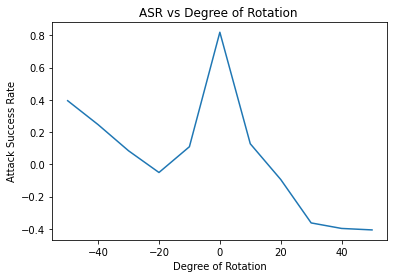

In [176]:
####################################################################################################################   
# Testing
####################################################################################################################
shifts = [-50,-40,-30,-20,-10,0,10,20,30,40,50]
scales = [50,60,70,80,90,100,110,120,130,140]
rotations = [-50,-40,-30,-20,-10,0,10,20,30,40,50]
x = []
y = []

for rotation in rotations:
    epoch_loss = []
    num_rois, score_adv, score_rand = 0, 0, 0
    rand_detections = 0 
    adv_detections = 0
    detected_rand = 0
    detected_adv = 0
    for fpath in tqdm(fpaths_test):
        input_img = Image.open(fpath)
        x_nat, x_bbox = letterbox_image_padded(input_img, size=detector.model_img_size)

        # Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
        detections_nat = detector.detect(x_nat)
        landmarks = fr.face_landmarks((np.array(x_nat.squeeze(0)*255).astype(int)).astype('uint8'))
        rois = extract_roi(detections_nat, detector.classes.index(SOURCE_CLASS), x_bbox, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)
        num_rois_x = len(rois)

        if len(landmarks) == 0:
            continue

        x_adv= x_nat.copy()

        # forehead                       
        x1,_ = landmarks[0]['right_eye'][len(landmarks[0]['right_eye'])-1]
        x2, _ = landmarks[0]['left_eye'][0]
        xmin = x1 + int((x2-x1)/2)
        _,ymin = landmarks[0]['left_eyebrow'][len(landmarks[0]['left_eyebrow'])//2 +1]
        if ymin>40:
            ymin-=40
        xmax , ymax = xmin+ PATCH_SIZE[0], ymin+PATCH_SIZE[1]
        x_adv[:, ymin:ymax, xmin:xmax, :] = headpatch

        # left cheek                        
        xmin,_ = landmarks[0]['left_eye'][0]
        _ , ymin = landmarks[0]['nose_bridge'][len(landmarks[0]['nose_bridge'])//2]

        xmax , ymax = xmin+ PATCH_SIZE[0], ymin+PATCH_SIZE[1]
        x_adv[:, ymin:ymax, xmin:xmax, :] = cheekpatch

        '''#IMAGE TRANSLATION
        img = x_adv.squeeze(0)
        height, width = img.shape[:2]
        shift_height, shift_width = shift , shift 
        T = np.float32([[1, 0, shift_width], [0, 1, shift_height]])
        translated = cv2.warpAffine(img, T, (width, height))
        translated = np.expand_dims(translated,axis = 0)
        
        #IMAGE WARPING
        img = x_adv.squeeze(0)
        scale_percent = scale
        final = int((scale_percent/100)*416)
        pts1 = np.float32([[0, 0], [0, 416], [416, 0], [416, 416]])
        pts2 = np.float32([[0, 0], [0, final], [final, 0], [final, final]])

        # Apply Perspective Transform Algorithm
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        warped = cv2.warpPerspective(img, matrix, (416, 416))
        warped = np.expand_dims(warped,axis=0)'''
        
        #IMAGE ROTATION
        img = x_adv.squeeze(0)
        image_center = tuple(np.array(img.shape[1::-1]) / 2)
        angle = rotation
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        rotated = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
        rotated = np.expand_dims(rotated,axis = 0)


        detections_adv = detector.detect(x_adv)
        detections_rand = detector.detect(rotated)
        
        rand_detections += len(rois)
        for i in range(len(detections_rand)):
            if int(detections_rand[i][0]) == 14:
                detected_rand +=1

        adv_detections += len(rois)
        for i in range(len(detections_adv)):
            if int(detections_adv[i][0]) == 14:
                detected_adv +=1

    ASR_TOG = detected_adv / adv_detections
    ASR_RAND = detected_rand / rand_detections
    ASR_TOG = 1 - ASR_TOG 
    ASR_RAND = 1 - ASR_RAND
    
    x.append(rotation)
    y.append(ASR_RAND)
    
    #print('shift:',shift)
    #print('TOG ASR RATE:',ASR_TOG,'detection rate:','(',detected_adv ,'/',adv_detections,')')
    #print('RANDOM ASR RATE:' ,ASR_RAND,'detection rate:','(',detected_rand ,'/',rand_detections,')')
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('Degree of Rotation')
# naming the y axis
plt.ylabel('Attack Success Rate')
  
# giving a title to my graph
plt.title('ASR vs Degree of Rotation ')
# function to show the plot
plt.show()